# Previsão de Doenças Cardiovasculares

O objetivo é prever a variável binária : ** Heart Disease Status ** .Sendo este, um problema de classificação, ideal para treinar modelos como Random Forest, Decision Tree ...

#### Dataset


O dataset elegido para este estudo foi **"Heart Disease Data for Health Research**, que contém características (features) que são cruciais no mundo real para o estudo de doeças cardiovascular, como:

> - Feature 1 - explicar
>
> - Feature 2 - explicar
>
> - Feature 3 - explicar
>

Podem ainda, ser considerados os seguintes atributos de risco: `feature 1 `  `feature 2 `

### Necessário

> **Dataset**  - `heart_diased.csv`
>
> **Obtido em** - `https://www.kaggle.com/datasets/oktayrdeki/heart-disease`


**Questões adicionais**

-Quais variáveis mais influenciam o risco? (feature importance)

-Modelos mais simples funcionam tão bem quanto modelos complexos?

-Podemos otimizar o recall sem perder muita precisão?

-Existe algum grupo com maior risco (ex.: idade, sexo)?
        

In [1]:
!pip install mlxtend
!pip install catboost
!pip install xgboost
!pip install lightgbm

In [1]:
# Manipulação de dados
import pandas as pd
import numpy as np
from collections import Counter

# Pré-processamento
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from imblearn.over_sampling import SMOTE

# Seleção de features
from sklearn.feature_selection import SelectFromModel

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier

import xgboost as xgb
from lightgbm import LGBMClassifier
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTETomek
from xgboost import XGBClassifier

# Validação e métricas
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, f1_score, roc_auc_score,
                             classification_report, confusion_matrix, ConfusionMatrixDisplay,
                             precision_recall_curve, silhouette_score)

# Clusterização e redução de dimensionalidade
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA

# Regras de associação
from mlxtend.frequent_patterns import apriori, association_rules

# Visualização
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

# Utilitários
import joblib
from scipy import stats

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Configuração padrão de plots
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['figure.dpi'] = 120


In [2]:
# import dataset
dataset_path = "./heart_disease.csv"
df = pd.read_csv(dataset_path)

# Formatação Data Set
df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace('...', '')

display(df.head())

# Debugg Extra
#print(df.columns)
#print(df.shape)
#print(df.info()) 

,age,gender,blood_pressure,cholesterol_level,exercise_habits,smoking,family_heart_disease,diabetes,bmi,high_blood_pressure,...,high_ldl_cholesterol,alcohol_consumption,stress_level,sleep_hours,sugar_consumption,triglyceride_level,fasting_blood_sugar,crp_level,homocysteine_level,heart_disease_status
0,56.0,Male,153.0,155.0,High,Yes,Yes,No,24.991591,Yes,...,No,High,Medium,7.633228,Medium,342.0,NaN,12.969246,12.387250,No
1,69.0,Female,146.0,286.0,High,No,Yes,Yes,25.221799,No,...,No,Medium,High,8.744034,Medium,133.0,157.0,9.355389,19.298875,No
2,46.0,Male,126.0,216.0,Low,No,No,No,29.855447,No,...,Yes,Low,Low,4.440440,Low,393.0,92.0,12.709873,11.230926,No
3,32.0,Female,122.0,293.0,High,Yes,Yes,No,24.130477,Yes,...,Yes,Low,High,5.249405,High,293.0,94.0,12.509046,5.961958,No
4,60.0,Male,166.0,242.0,Low,Yes,Yes,Yes,20.486289,Yes,...,No,Low,High,7.030971,High,263.0,154.0,10.381259,8.153887,No


***

## EDA - Análise Exploratória de Dados

De forma a entender a estrutura, qualidade e as relações subjacentes do dataset, e tendo em conta que o DataFrame é tanto numérico padronizado e categórico, a análise exploratória deve ser focada em duas áreas principais, a Visão Geral e Análise Bivariada.

As `colunas de exceção` contêm None como um possivel valor, porém este valor tem significado e deve ser mantido e não retirado como NaN. Porém é necessário tratar estes valor para que estes valores não sejam retirados do dataset, pois representam ~30% do dataset  

In [88]:
target_col = 'heart_disease_status'
column_execption = ["alcohol_consumption", "stress_level", "sugar_consumption", "exercise_habits"]
numeric_cols = ["age", "blood_pressure", "cholesterol_level", "bmi", "sleep_hours", 
                "triglyceride_level", "fasting_blood_sugar", "crp_level", "homocysteine_level"]


### Limpeza

In [90]:

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

for col in column_execption:
    df[col] = df[col].fillna("None")

df[target_col] = df[target_col].fillna('No').astype(str).str.strip()
y_mapped = df[target_col].map({'No': 0, 'Yes': 1})
df = df[y_mapped.notna()].copy()

cols_to_dropna_on = [col for col in df.columns if col not in column_execption and col != target_col]
df = df.dropna(subset=cols_to_dropna_on)
df = df.dropna(subset=numeric_cols)

y = df[target_col].map({'No': 0, 'Yes': 1}).astype(int)

print(f"Dataset: {len(df)} linhas")
print(f"Distribuição: {Counter(y)}")
print(f"Ratio: {Counter(y)[0]/Counter(y)[1]:.2f}:1")

Dataset: 9609 linhas
Distribuição: Counter({0: 7685, 1: 1924})
Ratio: 3.99:1


In [92]:

## Ignorar por enquanto !! --


print(f"\n{'='*60}")
print("FEATURE ENGINEERING")
print(f"{'='*60}")

df_X = df.drop(columns=[target_col])

# CRIAR INTERAÇÕES IMPORTANTES
# Risco cardiovascular composto
df_X['cardio_risk_1'] = df_X['cholesterol_level'] * df_X['blood_pressure'] / 100
df_X['cardio_risk_2'] = df_X['bmi'] * df_X['age'] / 100
df_X['cardio_risk_3'] = df_X['triglyceride_level'] * df_X['cholesterol_level'] / 1000

# Perfil metabólico
df_X['metabolic_score'] = (
    df_X['fasting_blood_sugar'] * 0.3 + 
    df_X['triglyceride_level'] * 0.3 + 
    df_X['cholesterol_level'] * 0.2 +
    df_X['bmi'] * 0.2
) / 100

# Inflamação composta
df_X['inflammation_score'] = df_X['crp_level'] * df_X['homocysteine_level']

# Estilo de vida
df_X['lifestyle_score'] = df_X['sleep_hours'] / (df_X['stress_level'].replace({'None': 0, 'Low': 1, 'Medium': 2, 'High': 3}) + 1)

# Idade ao quadrado (não-linearidade)
df_X['age_squared'] = df_X['age'] ** 2
df_X['bmi_squared'] = df_X['bmi'] ** 2

# Razões importantes
df_X['chol_hdl_ratio'] = df_X['cholesterol_level'] / (df_X['triglyceride_level'] + 1)
df_X['bp_age_ratio'] = df_X['blood_pressure'] / df_X['age']

print(f"Features originais + engineered: {df_X.shape[1]}") 



FEATURE ENGINEERING
Features originais + engineered: 31


In [56]:
cat_df = df.select_dtypes(include = ["object"])
cat_df.nunique()

for col in cat_df.columns:
    print(f"Column : {col}")
    print(cat_df[col].value_counts(),end = "\n\n")

Column : gender
gender
Male      4808
Female    4801
Name: count, dtype: int64

Column : exercise_habits
exercise_habits
High      3244
Medium    3194
Low       3146
None        25
Name: count, dtype: int64

Column : smoking
smoking
Yes    4932
No     4677
Name: count, dtype: int64

Column : family_heart_disease
family_heart_disease
No     4814
Yes    4795
Name: count, dtype: int64

Column : diabetes
diabetes
No     4842
Yes    4767
Name: count, dtype: int64

Column : high_blood_pressure
high_blood_pressure
Yes    4817
No     4792
Name: count, dtype: int64

Column : low_hdl_cholesterol
low_hdl_cholesterol
Yes    4820
No     4789
Name: count, dtype: int64

Column : high_ldl_cholesterol
high_ldl_cholesterol
No     4866
Yes    4743
Name: count, dtype: int64

Column : alcohol_consumption
alcohol_consumption
None      2490
Medium    2409
Low       2387
High      2323
Name: count, dtype: int64

Column : stress_level
stress_level
Medium    3248
Low       3187
High      3152
None        22
Nam

### Aprofundamento na Análise da Qualidade dos Dados

In [94]:
# ============================================
# 1. SEPARABILIDADE DAS CLASSES
# ============================================
print("\n" + "="*80)
print("1. AS CLASSES SÃO DISTINGUÍVEIS?")
print("="*80)

separability = []

for col in numeric_cols:
    class_0 = df[df[target_col] == 'No'][col].dropna()
    class_1 = df[df[target_col] == 'Yes'][col].dropna()
    
    # Teste estatístico
    stat, p_value = mannwhitneyu(class_0, class_1, alternative='two-sided')
    
    # Effect size (Cohen's d)
    mean_diff = class_1.mean() - class_0.mean()
    pooled_std = np.sqrt((class_0.std()**2 + class_1.std()**2) / 2)
    cohens_d = abs(mean_diff / pooled_std) if pooled_std > 0 else 0
    
    separability.append({
        'Feature': col,
        "Cohen's d": cohens_d,
        'p-value': p_value,
        'Média Sem Doença': class_0.mean(),
        'Média Com Doença': class_1.mean(),
        'Diferença %': abs(mean_diff / class_0.mean() * 100) if class_0.mean() != 0 else 0
    })

sep_df = pd.DataFrame(separability).sort_values("Cohen's d", ascending=False)

print("\nSEPARABILIDADE DAS FEATURES:")
print(sep_df.to_string(index=False))

print("\n" + "-"*80)
print("INTERPRETAÇÃO DO COHEN'S D:")
print("  < 0.2  → Efeito DESPREZÍVEL (classes praticamente idênticas)")
print("  0.2-0.5 → Efeito PEQUENO")
print("  0.5-0.8 → Efeito MÉDIO")
print("  > 0.8  → Efeito GRANDE")
print("-"*80)

# Contar features úteis
negligible = (sep_df["Cohen's d"] < 0.2).sum()
small = ((sep_df["Cohen's d"] >= 0.2) & (sep_df["Cohen's d"] < 0.5)).sum()
medium = ((sep_df["Cohen's d"] >= 0.5) & (sep_df["Cohen's d"] < 0.8)).sum()
large = (sep_df["Cohen's d"] >= 0.8).sum()

print(f"\n RESUMO:")
print(f"   Efeito Desprezível (< 0.2): {negligible} features")
print(f"   Efeito Pequeno (0.2-0.5):   {small} features")
print(f"   Efeito Médio (0.5-0.8):     {medium} features")
print(f"   Efeito Grande (> 0.8):      {large} features")

if negligible >= 7:
    print("\n PROBLEMA CRÍTICO: A maioria das features não discrimina as classes!")
    print("   → Pessoas COM e SEM doença têm valores muito similares")
elif small >= 5 and medium == 0 and large == 0:
    print("\n  PROBLEMA MODERADO: Features têm baixo poder discriminativo")
    print("   → Modelo terá dificuldade em aprender")
else:
    print("\n✓ Features têm algum poder discriminativo")



1. AS CLASSES SÃO DISTINGUÍVEIS?

SEPARABILIDADE DAS FEATURES:
            Feature  Cohen's d  p-value  Média Sem Doença  Média Com Doença  Diferença %
                bmi   0.054331 0.033551         28.993532         29.335191     1.178398
     blood_pressure   0.034299 0.178978        149.916721        149.316008     0.400698
 homocysteine_level   0.021254 0.402340         12.428666         12.520670     0.740255
                age   0.017826 0.473967         49.359141         49.035343     0.656004
          crp_level   0.014658 0.568915          7.470371          7.406888     0.849796
fasting_blood_sugar   0.013748 0.597794        120.155498        119.831601     0.269565
 triglyceride_level   0.003680 0.880072        250.460638        250.781705     0.128191
  cholesterol_level   0.001038 0.965028        225.323878        225.369023     0.020036
        sleep_hours   0.001017 0.966754          6.989776          6.987992     0.025523

---------------------------------------------


2. VISUALIZAÇÃO DAS DISTRIBUIÇÕES

✓ Gráfico salvo: distribuicoes_classes.png


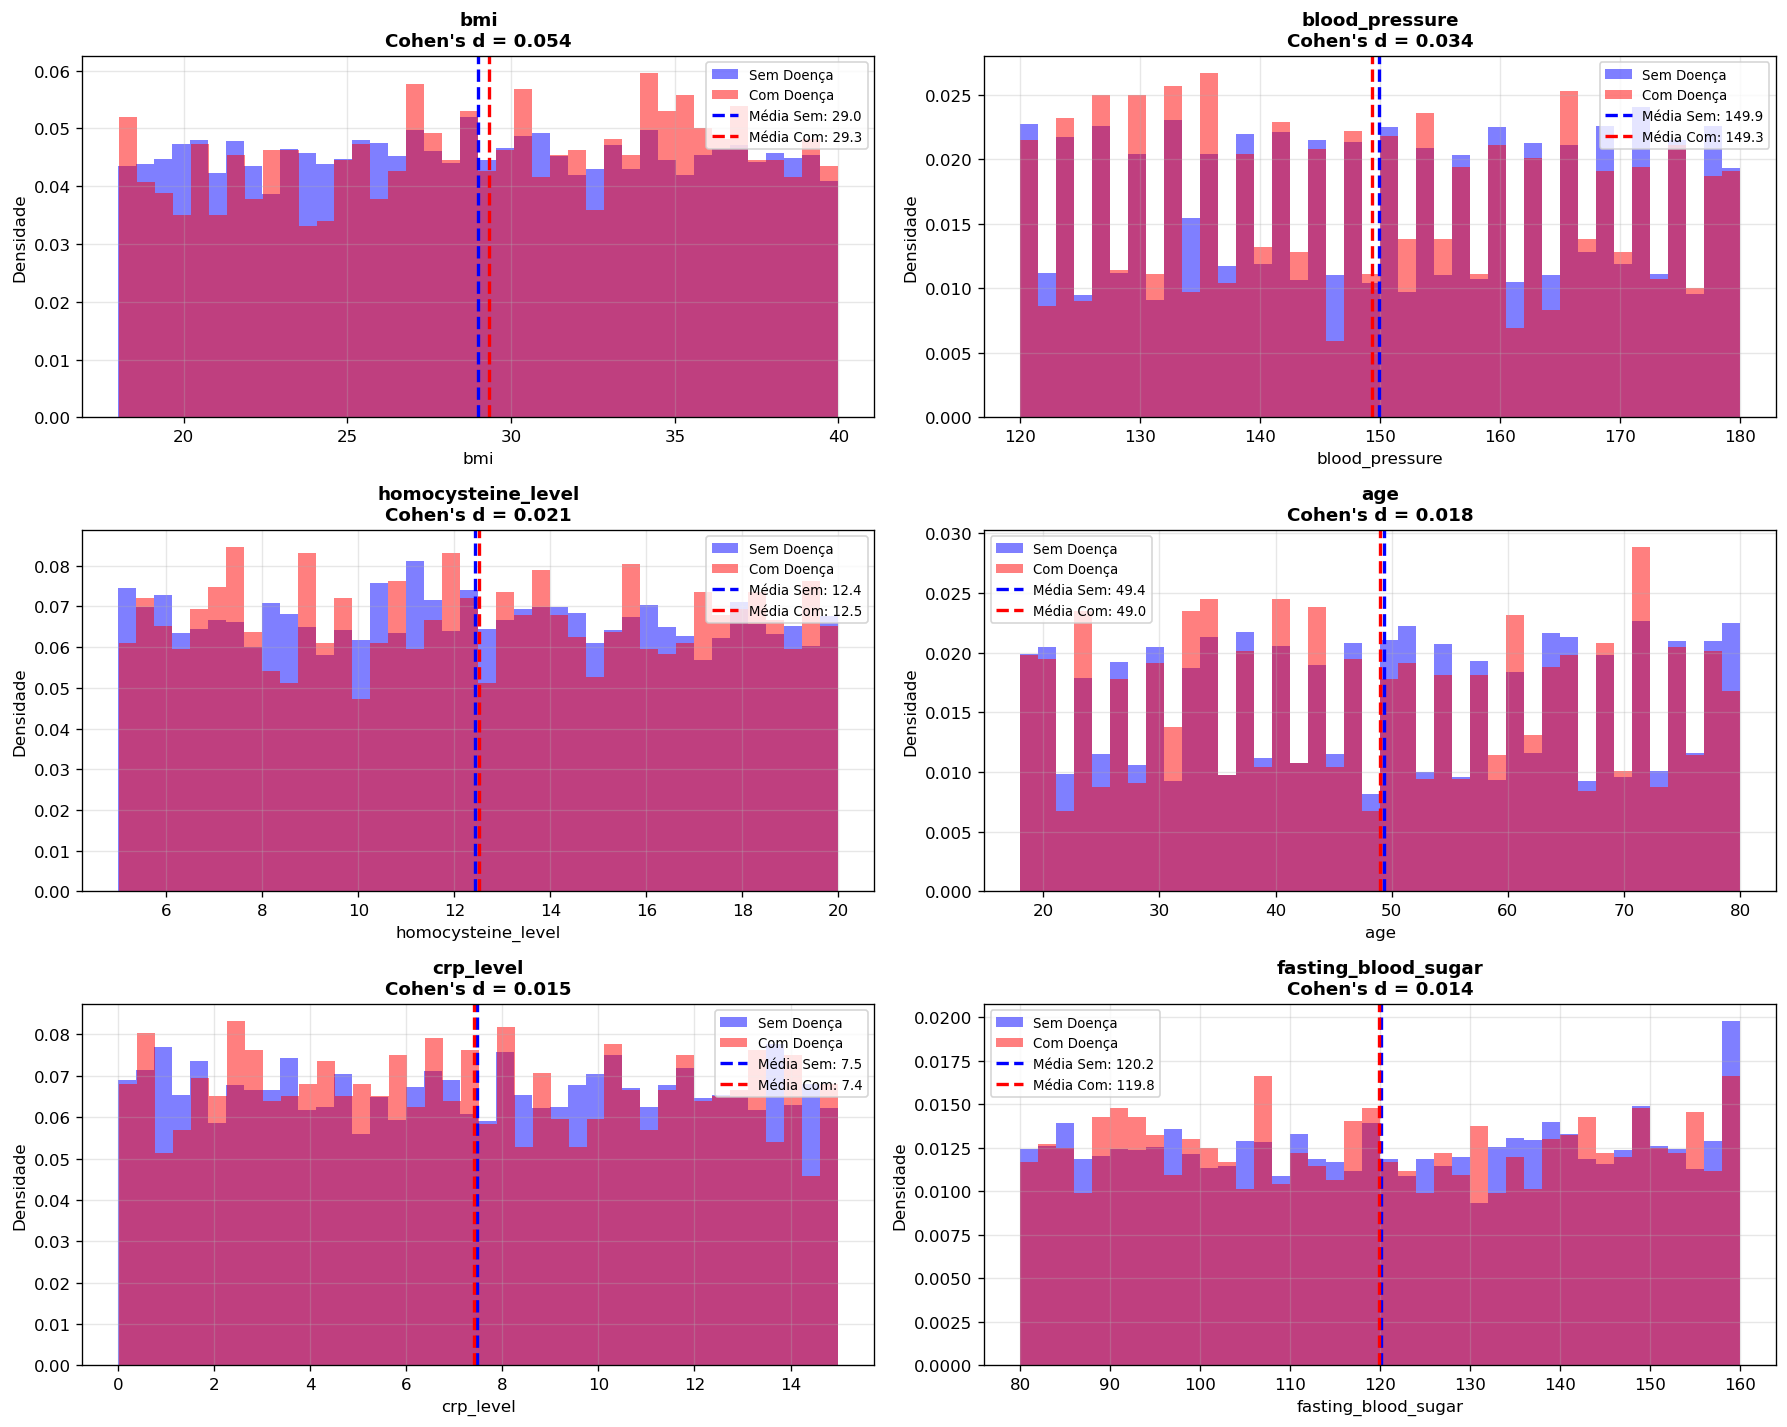


 Analise Grafica:
   - Se as curvas se SOBREPÕEM muito → classes são indistinguíveis
   - Se as médias estão PRÓXIMAS → baixo poder preditivo


In [95]:
print("\n" + "="*80)
print("2. VISUALIZAÇÃO DAS DISTRIBUIÇÕES")
print("="*80)

# Plotar top 6 features
top_6 = sep_df.head(6)['Feature'].tolist()

fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

for idx, col in enumerate(top_6):
    ax = axes[idx]
    
    class_0 = df[df[target_col] == 'No'][col].dropna()
    class_1 = df[df[target_col] == 'Yes'][col].dropna()
    
    # Histogramas
    ax.hist(class_0, bins=40, alpha=0.5, label='Sem Doença', color='blue', density=True)
    ax.hist(class_1, bins=40, alpha=0.5, label='Com Doença', color='red', density=True)
    
    # Médias
    ax.axvline(class_0.mean(), color='blue', linestyle='--', linewidth=2, label=f'Média Sem: {class_0.mean():.1f}')
    ax.axvline(class_1.mean(), color='red', linestyle='--', linewidth=2, label=f'Média Com: {class_1.mean():.1f}')
    
    cohens = sep_df[sep_df['Feature'] == col]["Cohen's d"].values[0]
    ax.set_title(f"{col}\nCohen's d = {cohens:.3f}", fontsize=11, fontweight='bold')
    ax.set_xlabel(col)
    ax.set_ylabel('Densidade')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('distribuicoes_classes.png', dpi=150, bbox_inches='tight')
print("\n✓ Gráfico salvo: distribuicoes_classes.png")
plt.show()

print("\n Analise Grafica:")
print("   - Se as curvas se SOBREPÕEM muito → classes são indistinguíveis")
print("   - Se as médias estão PRÓXIMAS → baixo poder preditivo")



3. VISUALIZAÇÃO PCA (2D)
Variância explicada pelo PC1: 11.63%
Variância explicada pelo PC2: 11.56%
Variância total explicada: 23.19%

✓ Gráfico salvo: pca_separabilidade.png


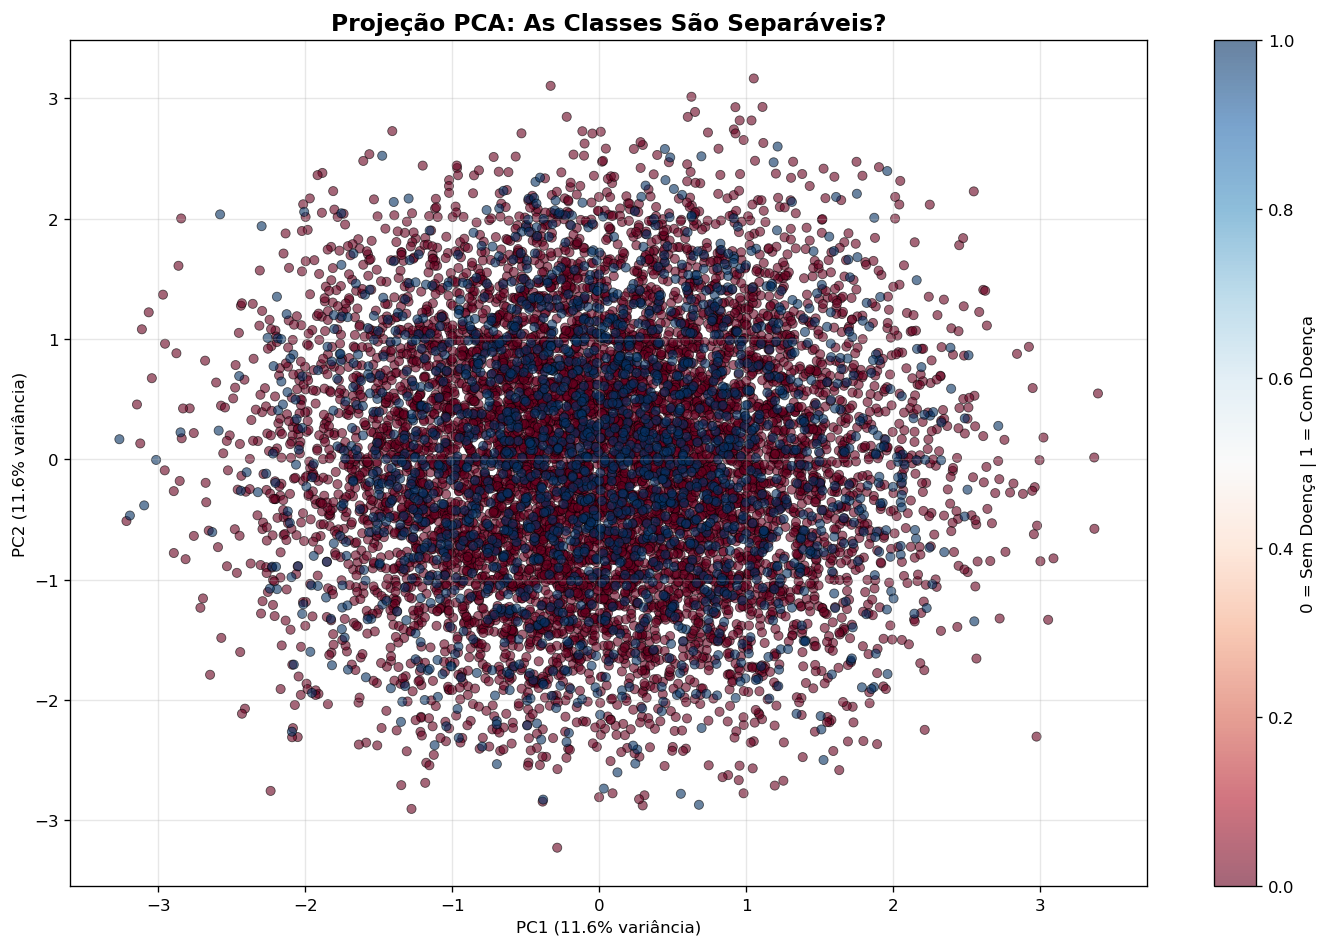


 INTERPRETAÇÃO DO PCA:
   - Pontos azuis (0) e vermelhos (1) MISTURADOS → classes não separáveis
   - Pontos bem SEPARADOS em grupos → classes distintas


In [97]:
print("\n" + "="*80)
print("3. VISUALIZAÇÃO PCA (2D)")
print("="*80)

# Preparar dados
X_numeric = df[numeric_cols].fillna(df[numeric_cols].median())
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print(f"Variância explicada pelo PC1: {pca.explained_variance_ratio_[0]*100:.2f}%")
print(f"Variância explicada pelo PC2: {pca.explained_variance_ratio_[1]*100:.2f}%")
print(f"Variância total explicada: {pca.explained_variance_ratio_.sum()*100:.2f}%")

# Plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], 
                     c=y, cmap='RdBu', alpha=0.6, s=30, edgecolors='k', linewidth=0.5)
plt.colorbar(scatter, label='0 = Sem Doença | 1 = Com Doença')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variância)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variância)')
plt.title('Projeção PCA: As Classes São Separáveis?', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('pca_separabilidade.png', dpi=150, bbox_inches='tight')
print("\n✓ Gráfico salvo: pca_separabilidade.png")
plt.show()

print("\n INTERPRETAÇÃO DO PCA:")
print("   - Pontos azuis (0) e vermelhos (1) MISTURADOS → classes não separáveis")
print("   - Pontos bem SEPARADOS em grupos → classes distintas")


In [98]:

# ============================================
# 4. SOBREPOSIÇÃO DAS DISTRIBUIÇÕES
# ============================================
print("\n" + "="*80)
print("4. QUANTIFICAÇÃO DA SOBREPOSIÇÃO")
print("="*80)

# Calcular overlap usando ranges
overlaps = []

for col in numeric_cols:
    class_0 = df[df[target_col] == 'No'][col].dropna()
    class_1 = df[df[target_col] == 'Yes'][col].dropna()
    
    min_0, max_0 = class_0.min(), class_0.max()
    min_1, max_1 = class_1.min(), class_1.max()
    
    # Overlap range
    overlap_min = max(min_0, min_1)
    overlap_max = min(max_0, max_1)
    
    if overlap_max > overlap_min:
        overlap_range = overlap_max - overlap_min
        total_range = max(max_0, max_1) - min(min_0, min_1)
        overlap_pct = (overlap_range / total_range * 100) if total_range > 0 else 0
    else:
        overlap_pct = 0
    
    overlaps.append({
        'Feature': col,
        'Sobreposição %': overlap_pct
    })

overlap_df = pd.DataFrame(overlaps).sort_values('Sobreposição %', ascending=False)

print("\nSOBREPOSIÇÃO DOS RANGES:")
print(overlap_df.to_string(index=False))

avg_overlap = overlap_df['Sobreposição %'].mean()
print(f"\n Sobreposição média: {avg_overlap:.1f}%")

if avg_overlap > 90:
    print("\nPROBLEMA CRÍTICO: Sobreposição > 90%")
    print("   → As distribuições são praticamente idênticas!")
elif avg_overlap > 80:
    print("\n  PROBLEMA SÉRIO: Sobreposição > 80%")
    print("   → Difícil separar as classes")
else:
    print("\n✓ Sobreposição aceitável")



4. QUANTIFICAÇÃO DA SOBREPOSIÇÃO

SOBREPOSIÇÃO DOS RANGES:
            Feature  Sobreposição %
                age      100.000000
     blood_pressure      100.000000
  cholesterol_level      100.000000
 triglyceride_level      100.000000
fasting_blood_sugar      100.000000
 homocysteine_level       99.973687
        sleep_hours       99.952262
          crp_level       99.950645
                bmi       99.936218

 Sobreposição média: 100.0%

PROBLEMA CRÍTICO: Sobreposição > 90%
   → As distribuições são praticamente idênticas!


In [99]:
# ============================================
# 5. ANÁLISE DE VARIÂNCIA
# ============================================
print("\n" + "="*80)
print("5. VARIÂNCIA INTRA-CLASSE vs INTER-CLASSE")
print("="*80)

variance_analysis = []

for col in numeric_cols:
    class_0 = df[df[target_col] == 'No'][col].dropna()
    class_1 = df[df[target_col] == 'Yes'][col].dropna()
    
    # Variância intra-classe (média das variâncias)
    within_var = (class_0.var() + class_1.var()) / 2
    
    # Variância inter-classe (diferença das médias)
    between_var = (class_1.mean() - class_0.mean()) ** 2
    
    # Ratio (quanto maior, melhor para separabilidade)
    ratio = between_var / within_var if within_var > 0 else 0
    
    variance_analysis.append({
        'Feature': col,
        'Ratio Between/Within': ratio,
        'Var Intra-Classe': within_var,
        'Var Inter-Classe': between_var
    })

var_df = pd.DataFrame(variance_analysis).sort_values('Ratio Between/Within', ascending=False)

print("\nRATIO VARIÂNCIA INTER/INTRA:")
print(var_df[['Feature', 'Ratio Between/Within']].to_string(index=False))

avg_ratio = var_df['Ratio Between/Within'].mean()
print(f"\nRatio médio: {avg_ratio:.4f}")

if avg_ratio < 0.01:
    print("\n PROBLEMA CRÍTICO: Variância entre classes << variância dentro das classes")
    print("   → Diferenças entre classes são insignificantes comparadas à variação natural")
elif avg_ratio < 0.1:
    print("\n  Baixo ratio: Difícil separar as classes")
else:
    print("\n✓ Ratio razoável para separação")



5. VARIÂNCIA INTRA-CLASSE vs INTER-CLASSE

RATIO VARIÂNCIA INTER/INTRA:
            Feature  Ratio Between/Within
                bmi              0.002952
     blood_pressure              0.001176
 homocysteine_level              0.000452
                age              0.000318
          crp_level              0.000215
fasting_blood_sugar              0.000189
 triglyceride_level              0.000014
  cholesterol_level              0.000001
        sleep_hours              0.000001

Ratio médio: 0.0006

 PROBLEMA CRÍTICO: Variância entre classes << variância dentro das classes
   → Diferenças entre classes são insignificantes comparadas à variação natural



2. VISUALIZAÇÃO DAS DISTRIBUIÇÕES

✓ Gráfico salvo: distribuicoes_classes.png


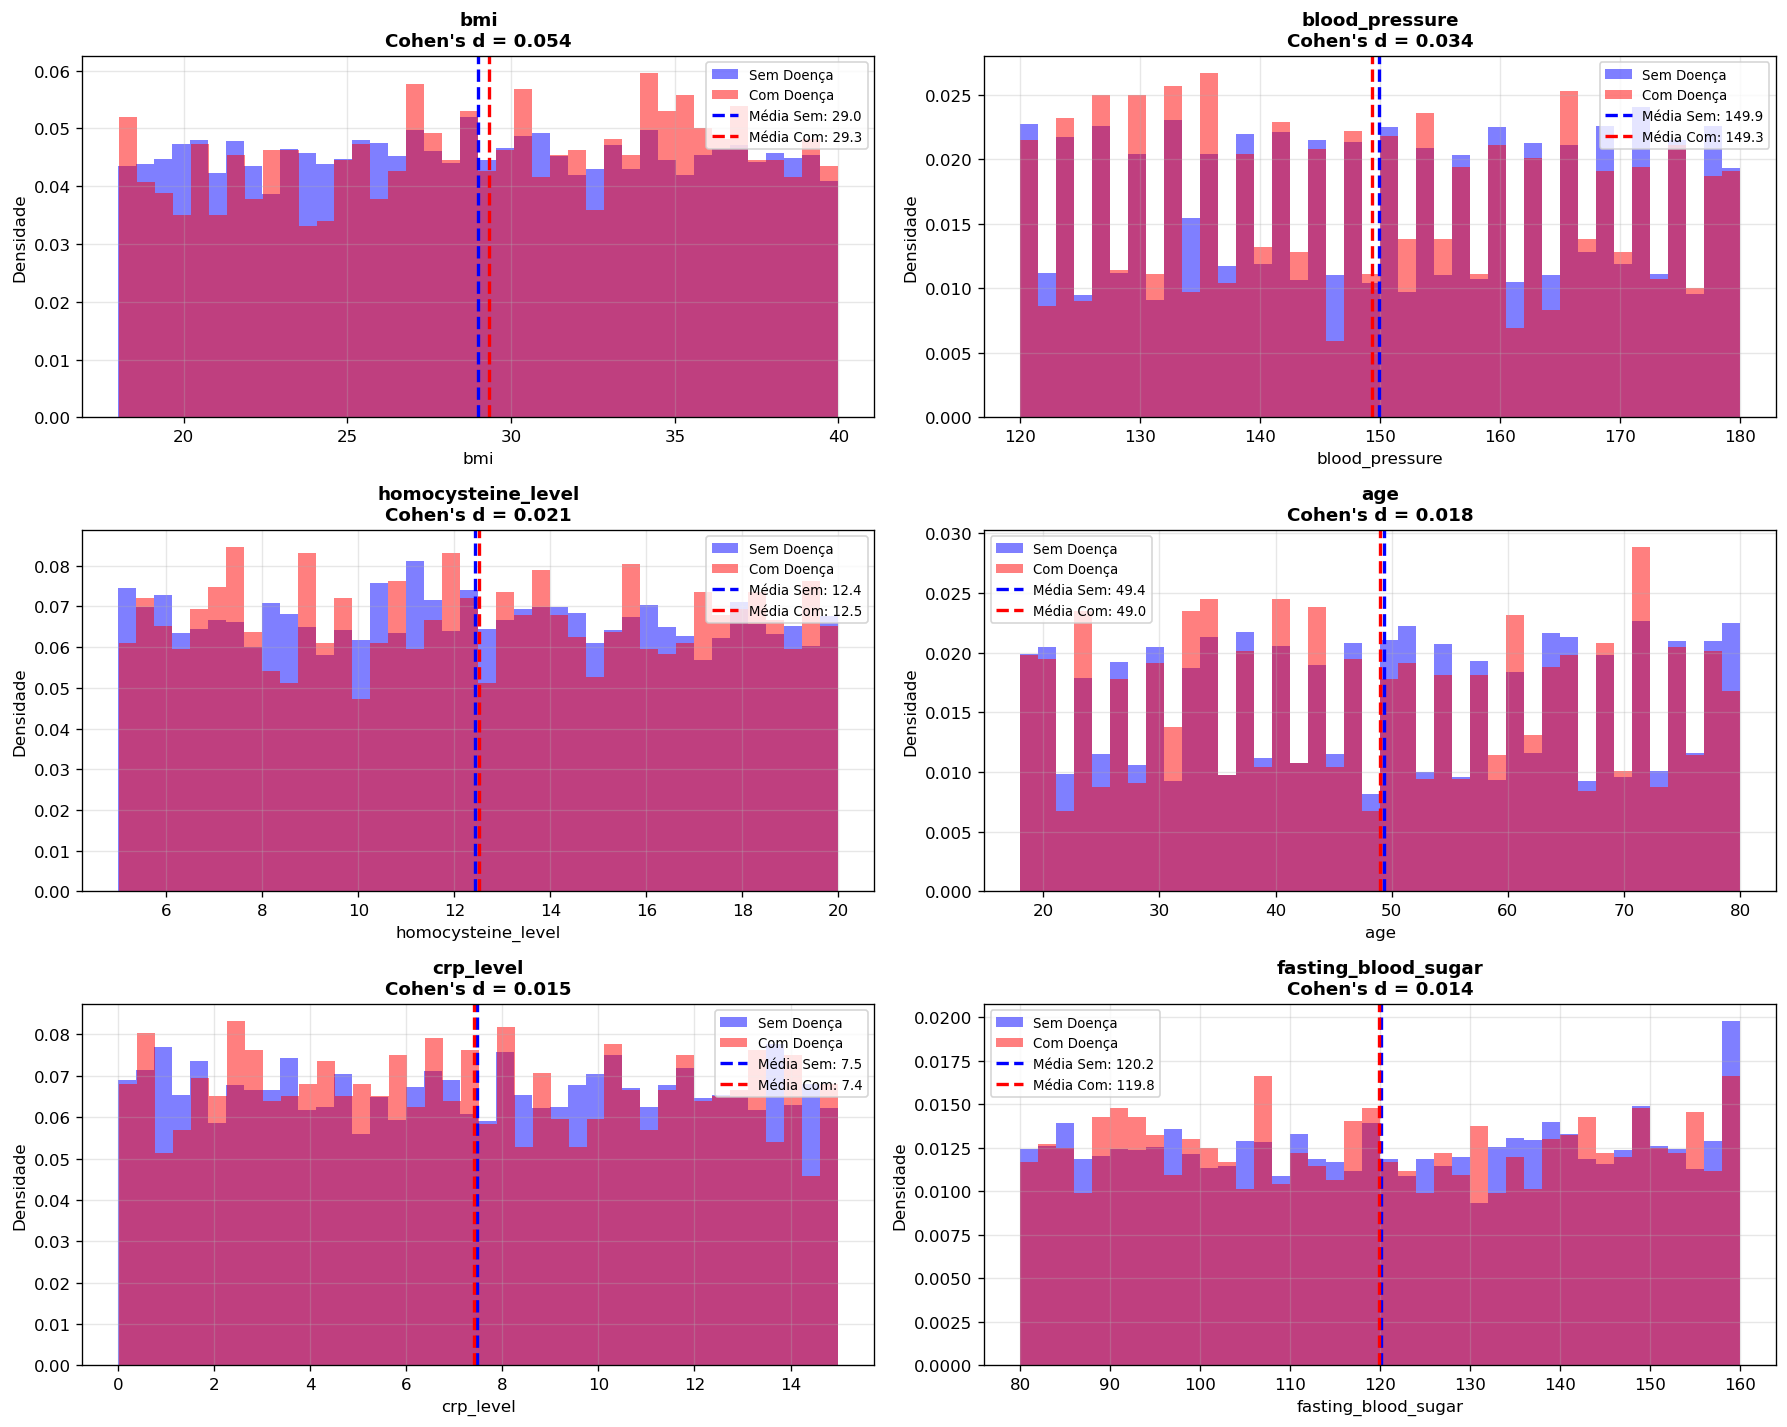


Interpretação  dos GRÁFICOS:
   - Se as curvas se SOBREPÕEM muito → classes são indistinguíveis
   - Se as médias estão PRÓXIMAS → baixo poder preditivo


In [100]:
print("\n" + "="*80)
print("2. VISUALIZAÇÃO DAS DISTRIBUIÇÕES")
print("="*80)

# Plotar top 6 features
top_6 = sep_df.head(6)['Feature'].tolist()

fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

for idx, col in enumerate(top_6):
    ax = axes[idx]
    
    class_0 = df[df[target_col] == 'No'][col].dropna()
    class_1 = df[df[target_col] == 'Yes'][col].dropna()
    
    # Histogramas
    ax.hist(class_0, bins=40, alpha=0.5, label='Sem Doença', color='blue', density=True)
    ax.hist(class_1, bins=40, alpha=0.5, label='Com Doença', color='red', density=True)
    
    # Médias
    ax.axvline(class_0.mean(), color='blue', linestyle='--', linewidth=2, label=f'Média Sem: {class_0.mean():.1f}')
    ax.axvline(class_1.mean(), color='red', linestyle='--', linewidth=2, label=f'Média Com: {class_1.mean():.1f}')
    
    cohens = sep_df[sep_df['Feature'] == col]["Cohen's d"].values[0]
    ax.set_title(f"{col}\nCohen's d = {cohens:.3f}", fontsize=11, fontweight='bold')
    ax.set_xlabel(col)
    ax.set_ylabel('Densidade')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('distribuicoes_classes.png', dpi=150, bbox_inches='tight')
print("\n✓ Gráfico salvo: distribuicoes_classes.png")
plt.show()

print("\nInterpretação  dos GRÁFICOS:")
print("   - Se as curvas se SOBREPÕEM muito → classes são indistinguíveis")
print("   - Se as médias estão PRÓXIMAS → baixo poder preditivo")

In [101]:
# ============================================
# 7. ESTATÍSTICAS DESCRITIVAS
# ============================================
print("\n" + "="*80)
print("ESTATÍSTICAS DESCRITIVAS POR CLASSE")
print("="*80)

print("\nCLASSE 0 (SEM DOENÇA):")
print(df[df[target_col] == 'No'][numeric_cols].describe().T[['mean', 'std', 'min', 'max']])

print("\n CLASSE 1 (COM DOENÇA):")
print(df[df[target_col] == 'Yes'][numeric_cols].describe().T[['mean', 'std', 'min', 'max']])

print("\n" + "="*80)
print("FIM DO DIAGNÓSTICO")
print("="*80)


ESTATÍSTICAS DESCRITIVAS POR CLASSE

CLASSE 0 (SEM DOENÇA):
                           mean        std         min         max
age                   49.359141  18.239145   18.000000   80.000000
blood_pressure       149.916721  17.597792  120.000000  180.000000
cholesterol_level    225.323878  43.687066  150.000000  300.000000
bmi                   28.993532   6.299501   18.002837   39.996954
sleep_hours            6.989776   1.751461    4.000773    9.999952
triglyceride_level   250.460638  87.044193  100.000000  400.000000
fasting_blood_sugar  120.155498  23.631038   80.000000  160.000000
crp_level              7.470371   4.355203    0.003647   14.997087
homocysteine_level    12.428666   4.318124    5.000236   19.999037

 CLASSE 1 (COM DOENÇA):
                           mean        std         min         max
age                   49.035343  18.089562   18.000000   80.000000
blood_pressure       149.316008  17.429479  120.000000  180.000000
cholesterol_level    225.369023  43.256085 

,count,mean,std,min,25%,50%,75%,max
age,9609.0,49.294307,18.208815,18.000000,34.000000,49.000000,65.000000,80.000000
blood_pressure,9609.0,149.796441,17.564962,120.000000,134.000000,150.000000,165.000000,180.000000
cholesterol_level,9609.0,225.332917,43.598874,150.000000,187.000000,225.000000,263.000000,300.000000
bmi,9609.0,29.061942,6.296253,18.002837,23.660967,29.059878,34.485684,39.996954
sleep_hours,9609.0,6.989418,1.752554,4.000605,5.449116,7.000856,8.532512,9.999952
triglyceride_level,9609.0,250.524925,87.122280,100.000000,176.000000,250.000000,326.000000,400.000000
fasting_blood_sugar,9609.0,120.090644,23.601258,80.000000,99.000000,120.000000,141.000000,160.000000
crp_level,9609.0,7.457660,4.345330,0.003647,3.648682,7.456422,11.236551,14.997087
homocysteine_level,9609.0,12.447088,4.322311,5.000236,8.717632,12.393262,16.137177,19.999037


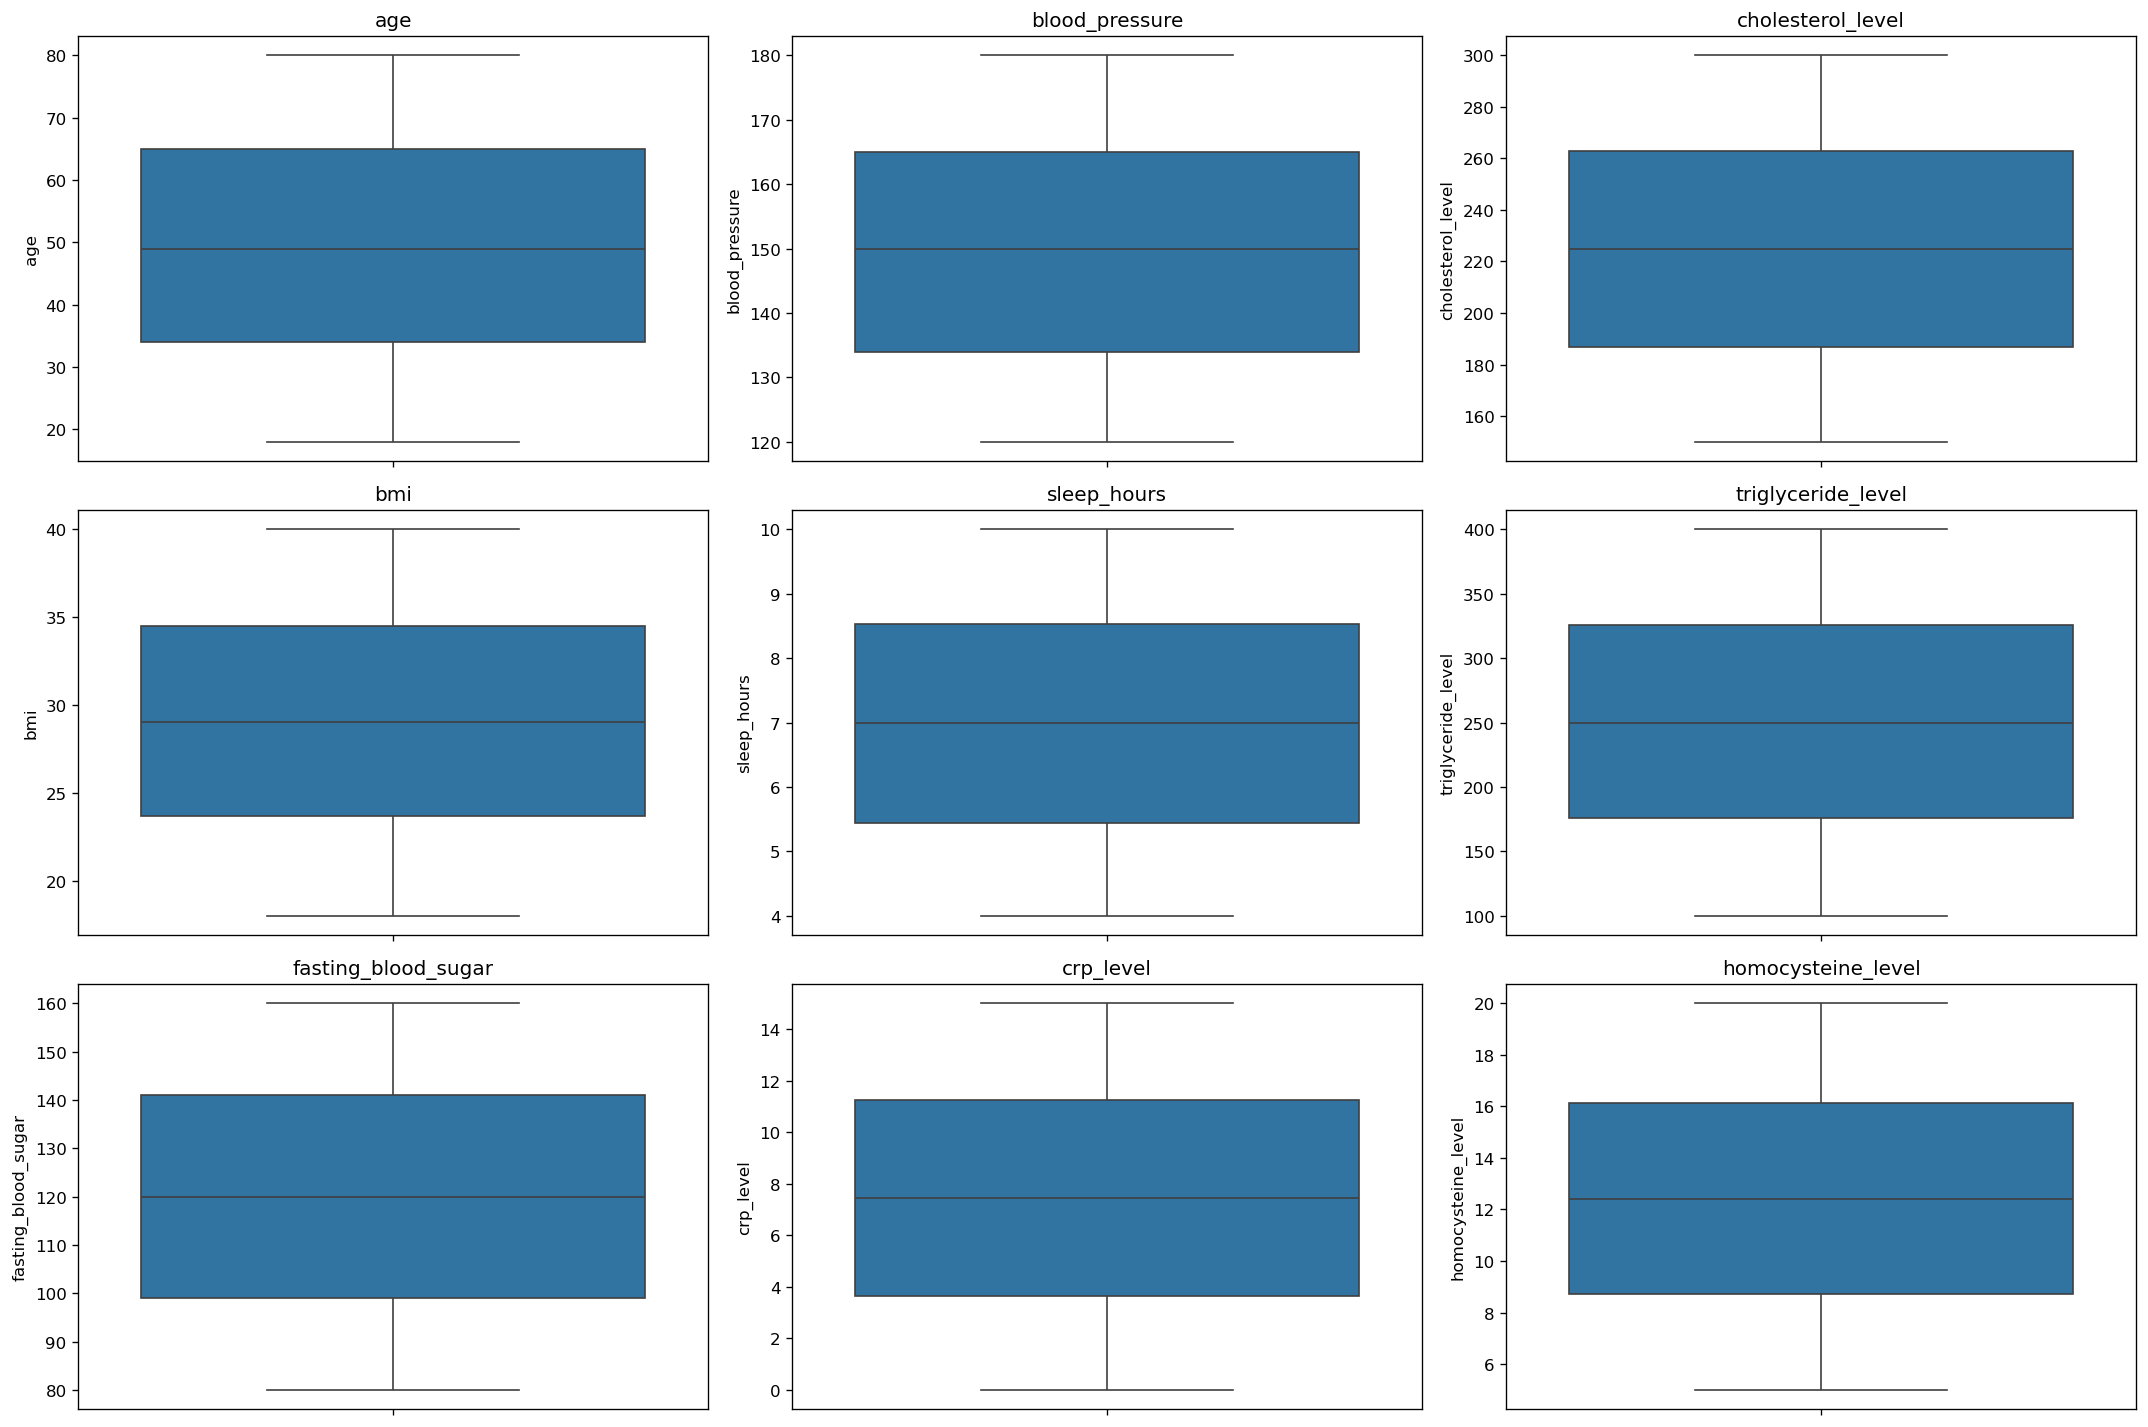

In [102]:
numeric_summary = df[numeric_cols].describe()
display(numeric_summary.T)

plt.figure(figsize=(18, 12))
for i, col in enumerate(numeric_cols):
    plt.subplot(3,3, i +1)
    sns.boxplot(y=df[col])
    plt.title(f'{col}')
    plt.ylabel(col)
plt.tight_layout()
plt.show()

`Conclusão` - Todas as variáveis seguem uma distribuição simétrica, sem outliers

**Expansão da Análise Bivariada**

`Numéricas vs. Target`, para permite ver rapidamente se a média ou a dispersão da variável numérica difere significativamente entre os dois grupos e como fundamento usamos um teste estatístico como o **Teste t**.

`Categóricas vs. Target`, para vizualizar a proporção de casos positivos e negativos de doença cardíaca dentro de cada categoria e como fundamento utilizamos um teste de associação **Qui-quadrado ( x^2)**, para avaliar se é estatisticamente significativa entre cada variável categórica e a variável target.

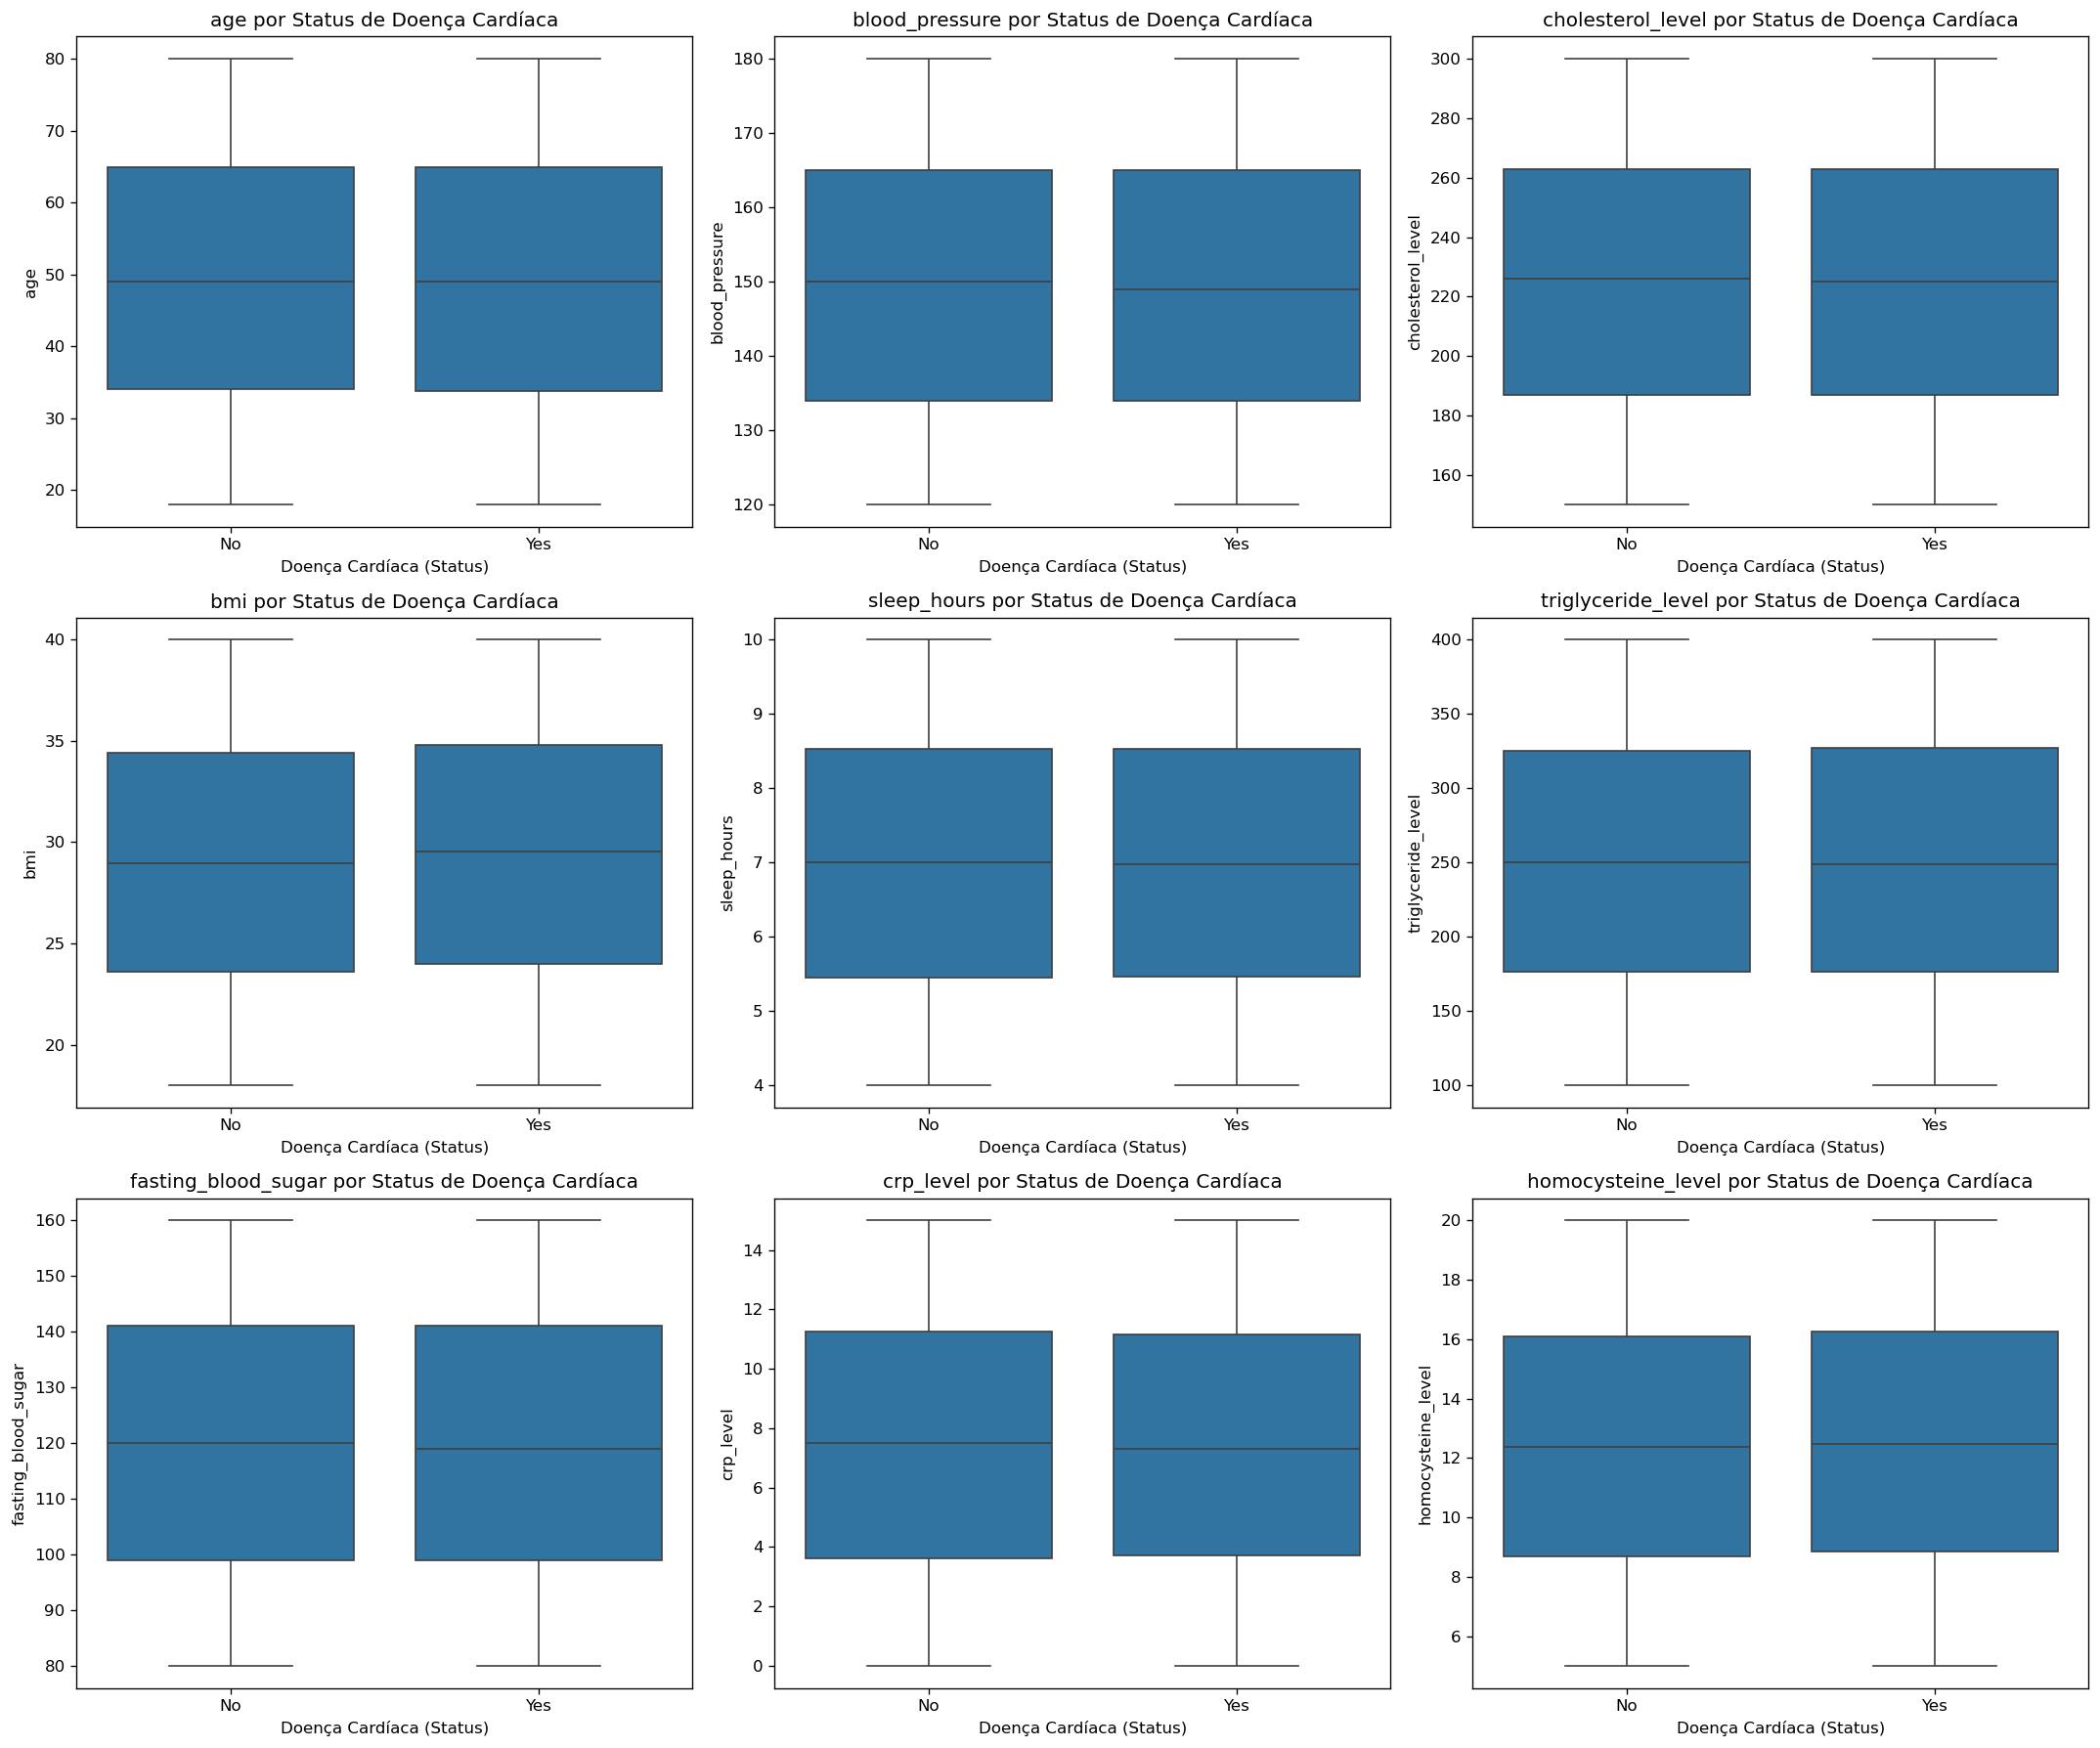

In [105]:
group_no = df[df[target_col] == 'No']
group_yes = df[df[target_col] == 'Yes']

plt.figure(figsize=(18, 15))
for i, col in enumerate(numeric_cols):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(x=df[target_col], y=df[col])
    plt.title(f'{col} por Status de Doença Cardíaca')
    plt.xlabel('Doença Cardíaca (Status)')
    plt.ylabel(col)
plt.tight_layout()
plt.show() 

### Definição do Número de Classes (k) — Método de Freedman–Diaconis


Aplicação de métodos estatísticos para determinar o número de classes - k em histogramas e agrupamentos. O métodos estatístico eleito para o risco por grupo de idade foi **Freedman-Diaconis**

Para agrupar a variável idade em intervalos (bins) de forma estatisticamente fundamentada, foi aplicado o método de Freedman–Diaconis, cuja largura das classes é dada por:

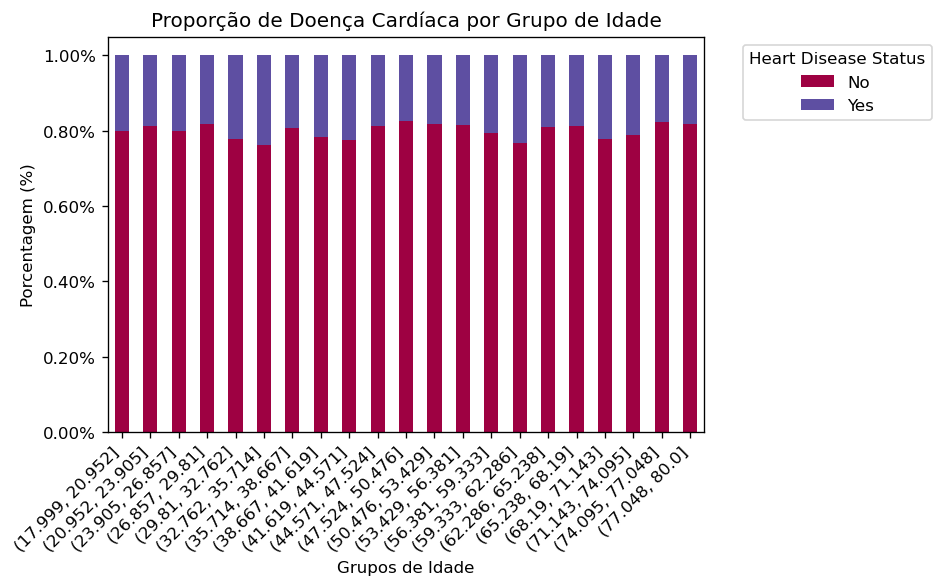

In [107]:
ages = df['age']
n = len(ages)

# Freedman-Diaconis formula
iqr = ages.quantile(.75) - ages.quantile(.25)
bin_width = 2 * iqr / (n ** (1/3))  

if bin_width == 0:
    k_fd = int(np.sqrt(n))
else:
    k_fd = int((ages.max() - ages.min()) / bin_width) 

k_fd = max(k_fd, 2)

bins = np.linspace(ages.min(), ages.max(), k_fd + 1)

df['age_group'] = pd.cut(df['age'], bins=bins, include_lowest = True)

age_status_prop = pd.crosstab(
    df['age_group'], 
    df['heart_disease_status'], 
    normalize='index'
)

iqr = df['age'].quantile(0.75) - df['age'].quantile(0.25)
df['age_group'].value_counts()

# Grafico
plt.figure(figsize=(8, 5))

age_status_prop.plot(
    kind='bar', 
    stacked=True, 
    colormap='Spectral', 
    ax=plt.gca()
)

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.title('Proporção de Doença Cardíaca por Grupo de Idade')
plt.ylabel('Porcentagem (%)')
plt.xlabel('Grupos de Idade')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Heart Disease Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Proporção de Doença Cardíaca por Grupo de Idade

Este gráfico empilhado representa, para cada faixa etária resultante do método de Freedman–Diaconis, a proporção de indivíduos com ou sem doença cardíaca.

Permite identificar tendências de risco ao longo da idade, ajudando a perceber se a prevalência ao usar grupos de idade derivados de um método robusto


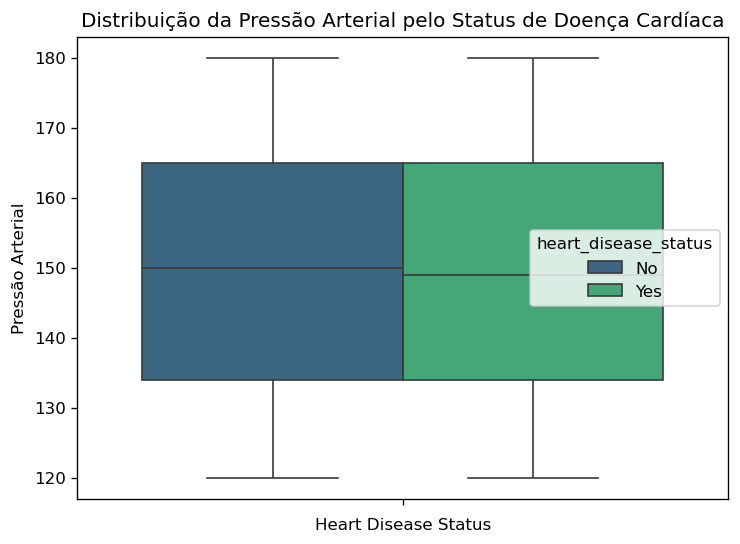

In [109]:
plt.figure(figsize=(7, 5))
sns.boxplot(
    hue='heart_disease_status', 
    y='blood_pressure', 
    data=df, 
    palette='viridis'
)
plt.title('Distribuição da Pressão Arterial pelo Status de Doença Cardíaca')
plt.xlabel('Heart Disease Status')
plt.ylabel('Pressão Arterial')
plt.show()

### Distribuição da Pressão Arterial por Status de Doença (Boxplot)

O boxplot compara a distribuição da variável contínua pressão arterial entre dois grupos: indivíduos com e sem doença cardíaca. Irá apresentar a mediana entre os grupos, amplitude interquartil e presença de outliers.

Se a pressão arterial apresentar deslocamento sistemático, isto sugere um maior risco

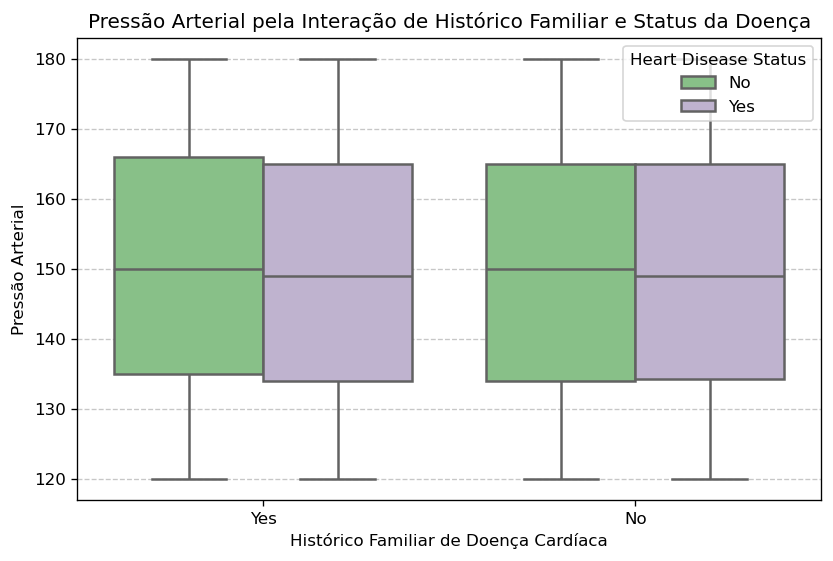

In [111]:
sns.boxplot(
    # Eixo X
    x='family_heart_disease',

    # Eixo Y
    y='blood_pressure',

    #target
    hue='heart_disease_status',

    data=df,
    palette='Accent',    
    linewidth=1.5
)

plt.title('Pressão Arterial pela Interação de Histórico Familiar e Status da Doença')
plt.xlabel('Histórico Familiar de Doença Cardíaca')
plt.ylabel('Pressão Arterial')
plt.legend(title='Heart Disease Status', loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Mapa de Calor da Matriz de Correlação

**Tipo Grafico**  `Heat Map`

O mapa de calor exibe as correlações entre todas as variáveis numéricas. 

> **Objetivo do Gráifo** - Entender as relações lineares fortes ou fracas entre variáveis, possíveis redundâncias ou variáveis com maior contributo para a variância.

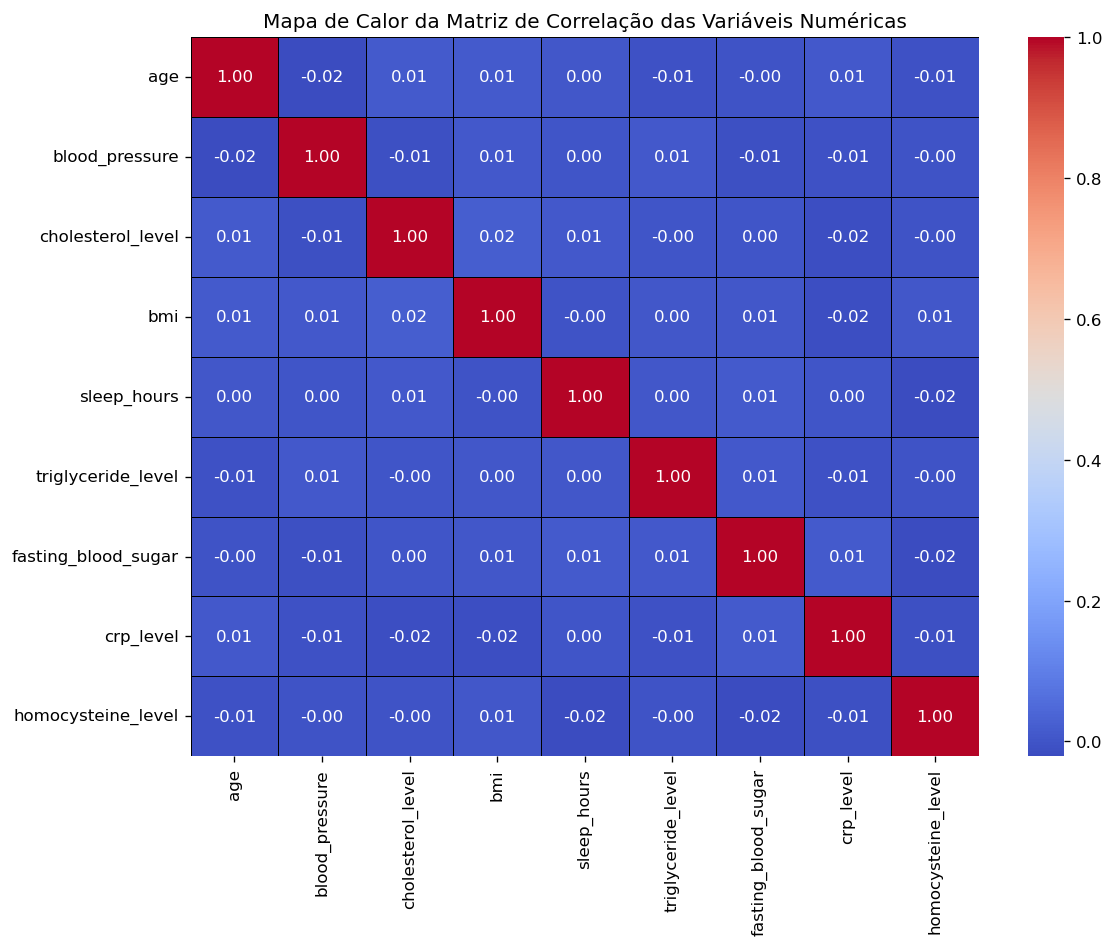

In [113]:
correlation_matrix = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,     
    cmap='coolwarm',
    fmt=".2f",      # Formato de duas casas decimais
    linewidths=.5,  # Linhas entre as células
    linecolor='black'
)
plt.title('Mapa de Calor da Matriz de Correlação das Variáveis Numéricas')
plt.tight_layout()
plt.show()

### Distribuição dos Níveis de Colesterol por Status da Doença 

**Tipo de Gráfico** `Violin Plot`


O violin plot combina a densidade de kernel com boxplot, permitindo uma visão detalhada da distribuição.

> **Objetivo** Com este gráfico é pretendido visualizar a forma completa da distribuiºão, diferenças de densidade entre individuos saudáveis e doentes e pontos de concentração e outliers

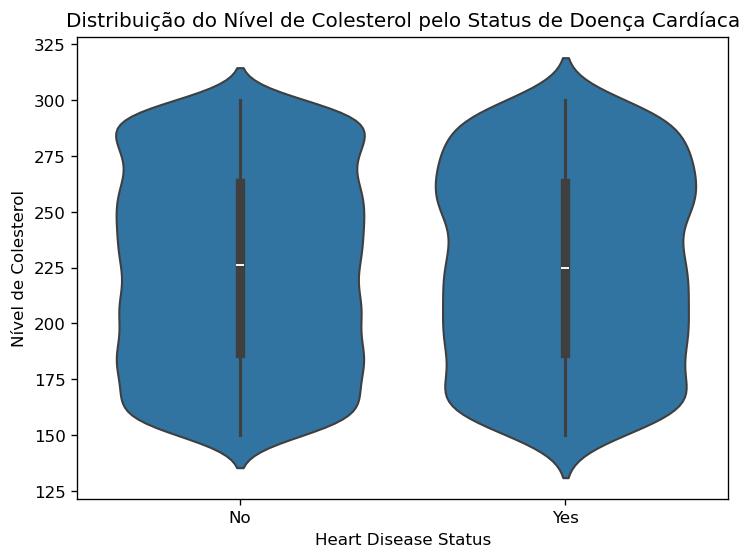

In [115]:
plt.figure(figsize=(7, 5))
sns.violinplot(
    x='heart_disease_status',
    y='cholesterol_level',
    data=df,
)
plt.title('Distribuição do Nível de Colesterol pelo Status de Doença Cardíaca')
plt.xlabel('Heart Disease Status')
plt.ylabel('Nível de Colesterol')
plt.show()

### Relação entre Pressão Arterial e Colesterol 

**Tipo Grafico**  `Scatter Plot`

Este scatter plot avalia a relação entre duas variáveis contínuas, com coloração de acordo com o estado da doença.

> **Objetivo** - Conseguir identificar padrões de correlação linear ou não linear, detetar clusters visuais entre grupos, observar outliers bidimensionais e explorar potenciais relações de causa-associação.

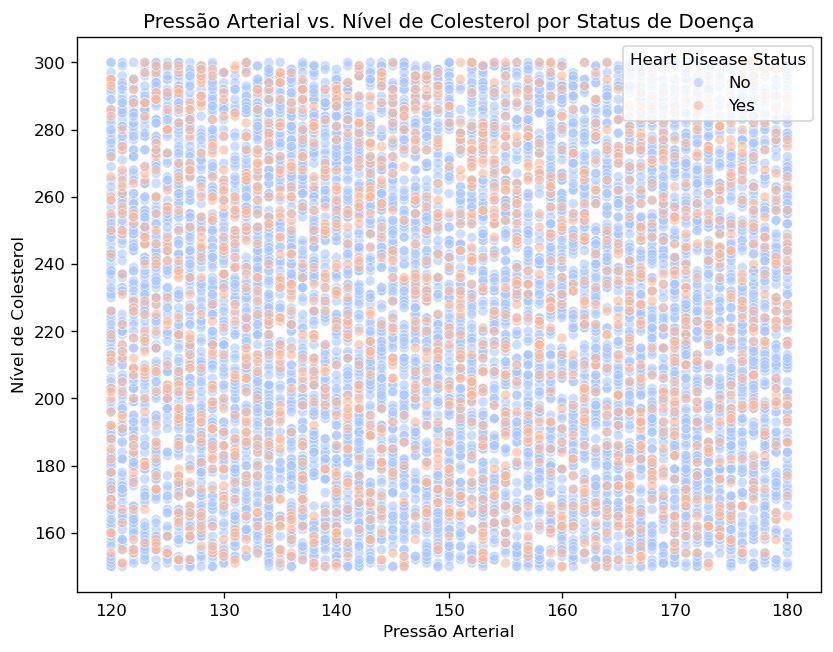

In [117]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='blood_pressure',
    y='cholesterol_level',
    hue='heart_disease_status',
    data=df,
    palette='coolwarm',
    alpha=0.6
)
plt.title('Pressão Arterial vs. Nível de Colesterol por Status de Doença')
plt.xlabel('Pressão Arterial')
plt.ylabel('Nível de Colesterol')
plt.legend(title='Heart Disease Status')
plt.show()

### Análise de Proporção em Variáveis Categóricas Chave

O objetivo é descobrir se alguma 

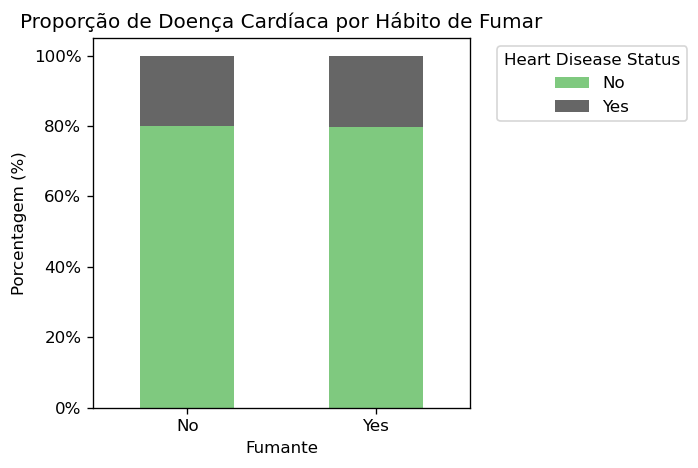

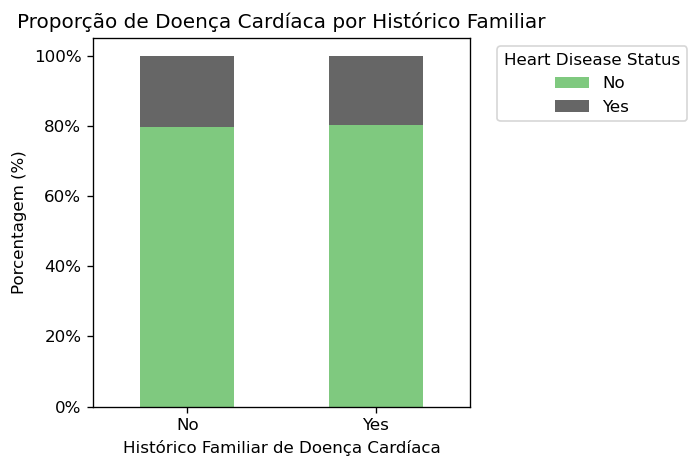

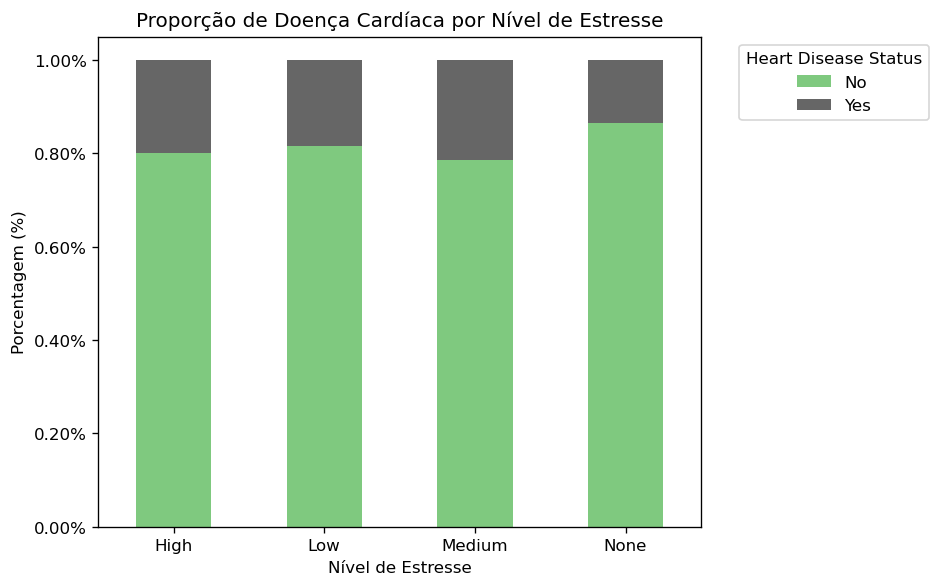

In [119]:
smoking_status_prop = pd.crosstab(
    df['smoking'],
    df['heart_disease_status'],
    normalize='index'
) * 100


plt.figure(figsize=(6, 4))
smoking_status_prop.plot(kind='bar', stacked=True, colormap='Accent', ax=plt.gca())

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.title('Proporção de Doença Cardíaca por Hábito de Fumar')
plt.ylabel('Porcentagem (%)')
plt.xlabel('Fumante')
plt.xticks(rotation=0)
plt.legend(title='Heart Disease Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


family_status_prop = pd.crosstab(
    df['family_heart_disease'],
    df['heart_disease_status'],
    normalize='index'
) * 100

plt.figure(figsize=(6, 4))
family_status_prop.plot(kind='bar', stacked=True, colormap='Accent', ax=plt.gca())

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.title('Proporção de Doença Cardíaca por Histórico Familiar')
plt.ylabel('Porcentagem (%)')
plt.xlabel('Histórico Familiar de Doença Cardíaca')
plt.xticks(rotation=0)
plt.legend(title='Heart Disease Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


stress_status_prop = pd.crosstab(
    df['stress_level'],
    df['heart_disease_status'],
    normalize='index'
)

plt.figure(figsize=(8, 5))
stress_status_prop.plot(kind='bar', stacked=True, colormap='Accent', ax=plt.gca())

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.title('Proporção de Doença Cardíaca por Nível de Estresse')
plt.ylabel('Porcentagem (%)')
plt.xlabel('Nível de Estresse')
plt.xticks(rotation=0)
plt.legend(title='Heart Disease Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Conclusão EDA - Ñ atualizada

Na distribuição independente do dataset os valores estão balanceados, no intanto o `target_value`é imbalanciado, sendo este nivel de 20% - 80%

Considerações para a **Fase de Modelação**

O imbalanceamento do dataser pode causar tendência a favor da class "No", que representa a maioria, que consequentemente irá tornar mais dificil a previsão correta da classe "Yes" que é a minoria.

Considerando o imbalanceamento as seguintes técnicas seram consideradas :

- `SMOTE`, com o âmbito de aumentar a class da minoria
- `Peso da Classe`
- `F1-Score`
- `Precision-Recal`, invés de basearmo-nos apenas na precisão

### Interpetação dos Graficos 

Os resultados representados são os espectados uma vez que a correlação linear próxima de zero - dado pelo mapa de calor e regressão linear - é a prova estatística de que modelos que assumem uma relação regressão linear ou logística simples serão ineficazes.

O Gráfico de Barras mostra que, independentemente do grupo de idade, a prevalência de doença cardíaca neste conjunto de dados é consistentemente alta, indicando que a idade por si só (como um único fator contínuo) não é o único motor linear da doença, mas sim um forte fator de risco quando categorizada.

É possível verificar a idade é um forte preditor de pertencer a um grupo de alto risco, mas a forma como a doença se manifesta não é linear no nosso conjunto de dados (todos os grupos têm a mesma prevalência alta).

>A baixa correlação linear é um facto estatístico neste conjunto de dados, mas não implica total independência na realidade clínica. Significa apenas que um modelo de regressão linear simples não seria eficaz.

O principal desafio encontrado nesta análise é que os fatores de risco tradicionais (Idade, Pressão Arterial, Colesterol, etc.) não estão a demonstrar o poder preditivo esperado de forma isolada e linear. A análise mostra consistentemente que o problema não reside nas correlações lineares nem nas relações de proporção simples com as variáveis categóricas mais óbvias.

Assim após a análise exploratória dos dados é possivel concluir que podemos descartar as relações lineares e isoladas. Usar modelos de Machine Learning não-lineares (como Random Forests ou Redes Neurais) para capturar a complexa interação entre os fatores.


***

## Regras de Associação à Priori - IGNORAR


De forma a percebemos qual antecedente, X implica um consequente, Y devemos determinar as métricas para usar num algoritmo à priori, onde a frequência onde X e Y aparecem juntos no conjunto de total de transações. Devemos também ter em conta a **confiança**, ou seja a probabilidade de um consquente estar associado ao antecedente. 


In [124]:
list_of_apriori_cols = [
    "age",
    "gender",
    "blood_pressure",
    "cholesterol_level",
    "exercise_habits",
    "smoking",
    "family_heart_disease",
    "diabetes",
    "bmi",
    "high_blood_pressure",
    "high_ldl_cholesterol",
    "alcohol_consumption",
    "stress_level",
    "sleep_hours",
    "sugar_consumption",
    "triglyceride_level",
    "fasting_blood_sugar",
    "crp_level",
    "homocysteine_level",
    "heart_disease_status"
]

# Criar cópia para não afetar o DataFrame original
df_apriori = df[list_of_apriori_cols].copy()

# 1. DISCRETIZAR VARIÁVEIS NUMÉRICAS CONTÍNUAS
# Age (já tem age_group, mas vou refazer aqui)
df_apriori['age_cat'] = pd.cut(
    df_apriori['age'], 
    bins=[0, 30, 45, 60, 100], 
    labels=['Jovem', 'Adulto', 'Meia-idade', 'Idoso']
)

# Blood Pressure
df_apriori['bp_cat'] = pd.cut(
    df_apriori['blood_pressure'],
    bins=[0, 120, 140, 200],
    labels=['Normal', 'Elevada', 'Alta']
)

# Cholesterol
df_apriori['chol_cat'] = pd.cut(
    df_apriori['cholesterol_level'],
    bins=[0, 200, 240, 500],
    labels=['Desejável', 'Limítrofe', 'Alto']
)

# BMI
df_apriori['bmi_cat'] = pd.cut(
    df_apriori['bmi'],
    bins=[0, 18.5, 25, 30, 50],
    labels=['Baixo_Peso', 'Normal', 'Sobrepeso', 'Obeso']
)

# Sleep Hours
df_apriori['sleep_cat'] = pd.cut(
    df_apriori['sleep_hours'],
    bins=[0, 6, 8, 12],
    labels=['Pouco', 'Adequado', 'Muito']
)

# Triglycerides
df_apriori['trig_cat'] = pd.cut(
    df_apriori['triglyceride_level'],
    bins=[0, 150, 200, 1000],
    labels=['Normal', 'Limítrofe', 'Alto']
)

# Fasting Blood Sugar
df_apriori['fbs_cat'] = pd.cut(
    df_apriori['fasting_blood_sugar'],
    bins=[0, 100, 126, 300],
    labels=['Normal', 'Pré-diabetes', 'Diabetes']
)

# CRP Level
df_apriori['crp_cat'] = pd.cut(
    df_apriori['crp_level'],
    bins=[0, 1, 3, 100],
    labels=['Baixo', 'Moderado', 'Alto']
)

# Homocysteine
df_apriori['hcy_cat'] = pd.cut(
    df_apriori['homocysteine_level'],
    bins=[0, 10, 15, 100],
    labels=['Normal', 'Moderado', 'Alto']
)

categorical_cols = [
    'age_cat', 'gender', 'bp_cat', 'chol_cat', 'exercise_habits',
    'smoking', 'family_heart_disease', 'diabetes', 'bmi_cat',
    'high_blood_pressure', 'high_ldl_cholesterol', 'alcohol_consumption',
    'stress_level', 'sleep_cat', 'sugar_consumption', 'trig_cat',
    'fbs_cat', 'crp_cat', 'hcy_cat', 'heart_disease_status'
]

In [125]:
freq_items = apriori(
    df_apriori_ready, 
    min_support=0.05,
    use_colnames=True,
    max_len=4
)

# Gerar regras
rules = association_rules(
    freq_items, 
    metric='confidence', 
    min_threshold=0.7 
)

print("Regras antes do filtro")
display(rules)

# Filtrar regras relevantes
rules_hd = rules[
    rules['consequents'].apply(lambda x: 'heart_disease_status=Yes' in str(x))
].sort_values('lift', ascending=False)


print("\n\nRegras depois da filtragem")
display(rules_hd[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

NameError: name 'df_apriori_ready' is not defined

### Conclusão das Regras de Associação

No teu dataset, não existe nenhum conjunto simples de fatores (antecedentes) cuja ocorrência aumente significativamente a probabilidade de “heart_disease = Yes” (consequente) ao nível mínimo exigido pelos algoritmos de associação

Estes resultados juntando aos resultados do EDA, reforça a necessidade de usar:

- Random Forest

- XGBoost

- Modelos não lineares

- SHAP para interpretar relações complexas

>Como as regras de associação Apriori indicaram não linearidade iremos optar pelas **Decison Rules** . 
>Estas regras, não dependem de suporte, confiança e capturam não linearidade. geram regras interpretáveis mesmo quando Apriori falha.

## Decison Rules

## K-Means - INGORAR 

Tenta agrupar os dados em k clusters minimizando a distância Euclidiana ao centroide do cluster. Como os dados têm relações não lineares complexas, o K-Means pode não separar bem os grupos, formando um anel concênctrico

pca = PCA(n_components=2)
pc = pca.fit_transform(df_X)

hc = AgglomerativeClustering(n_clusters=3, linkage='ward')
labels_hc = hc.fit_predict(df_X)

plt.figure(figsize=(10, 6))
plt.scatter(pc[:, 0], pc[:, 1], c=labels_hc, cmap='viridis', alpha=0.6)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Clustering Hierárquico (Ward) com PCA')
plt.colorbar(label='Cluster')
plt.show()

inertia = []
silhouette = []

# k de 1 a 10
K_range_inertia = range(1, 11)
K_range_silhouette = range(2, 11)

for k in K_range_inertia:
    kmeans = KMeans(n_clusters = k, random_state=42, n_init='auto') 
    kmeans.fit(df_X)
    
    inertia.append(kmeans.inertia_)

for k in K_range_silhouette:
    kmeans = KMeans(n_clusters = k, random_state=42, n_init='auto') 
    kmeans.fit(df_X)
    
    score = silhouette_score(df_X, kmeans.labels_)
    silhouette.append(score)

plt.figure(figsize=(10, 6))
plt.plot(K_range_inertia, inertia, marker='o')
plt.title('Método do Cotovelo para K-Means')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Inércia (WCSS)')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(K_range_silhouette, silhouette, marker='o')
plt.title('Coeficiente de Silhoutte p/número de clusters')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Silhouette Score')
plt.show()

plt.figure(figsize=(8,6))
plt.scatter(pc[:,0], pc[:,1], c = labels_hc)
plt.title("Hierarchical Clustering (Ward)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


#Z = linkage(df_X, method='ward')

#plt.figure(figsize=(12, 6))
#dendrogram(Z)
#plt.title("Dendrograma - Método Ward")
#plt.xlabel("Amostras")
#plt.ylabel("Distância")
#plt.show()

### One-Hot Enconding & Ordinal Enconding

Devido ao teor da pesquisa é importante usar Ordinal Enconding para variáveis que possuem uma escala real, como 
`alcohol_consumption`, `stress_level`, `sugar_consumption`, `exercise_habits` pela ordem: ['None', 'Low', 'Medium', 'High']

Para as restante variáveis não numéricas usamos One-Hot Enconding para obter uma valor binário

In [129]:
order = [['None', 'Low', 'Medium', 'High']] * len(column_execption)
encoder = OrdinalEncoder(categories=order)
df_X[column_execption] = encoder.fit_transform(df_X[column_execption])

df_X = pd.get_dummies(df_X, drop_first=False)
bool_cols = df_X.select_dtypes(include=['bool']).columns
df_X[bool_cols] = df_X[bool_cols].astype(int)

if 'age_group' in df_X.columns:
    df_X = df_X.drop(columns=['age_group'])

df_X = df_X.fillna(df_X.median())

print(f"Features após encoding: {df_X.shape[1]}")

Features após encoding: 58


In [131]:

print(f"\n{'='*60}")
print("FEATURE ENGINEERING")
print(f"{'='*60}")

df_X = df.drop(columns=[target_col])

# LIMPAR NOMES DAS COLUNAS (remover caracteres especiais)
df_X.columns = df_X.columns.str.replace('[', '_', regex=False)
df_X.columns = df_X.columns.str.replace(']', '_', regex=False)
df_X.columns = df_X.columns.str.replace('<', 'lt', regex=False)
df_X.columns = df_X.columns.str.replace('>', 'gt', regex=False)
df_X.columns = df_X.columns.str.replace(',', '_', regex=False)
df_X.columns = df_X.columns.str.replace(' ', '_', regex=False)

# CRIAR INTERAÇÕES IMPORTANTES
# Risco cardiovascular composto
df_X['cardio_risk_1'] = df_X['cholesterol_level'] * df_X['blood_pressure'] / 100
df_X['cardio_risk_2'] = df_X['bmi'] * df_X['age'] / 100
df_X['cardio_risk_3'] = df_X['triglyceride_level'] * df_X['cholesterol_level'] / 1000

# Perfil metabólico
df_X['metabolic_score'] = (
    df_X['fasting_blood_sugar'] * 0.3 + 
    df_X['triglyceride_level'] * 0.3 + 
    df_X['cholesterol_level'] * 0.2 +
    df_X['bmi'] * 0.2
) / 100

# Inflamação composta
df_X['inflammation_score'] = df_X['crp_level'] * df_X['homocysteine_level']

# Estilo de vida
df_X['lifestyle_score'] = df_X['sleep_hours'] / (df_X['stress_level'].replace({'None': 0, 'Low': 1, 'Medium': 2, 'High': 3}) + 1)

# Idade ao quadrado (não-linearidade)
df_X['age_squared'] = df_X['age'] ** 2
df_X['bmi_squared'] = df_X['bmi'] ** 2

# Razões importantes
df_X['chol_hdl_ratio'] = df_X['cholesterol_level'] / (df_X['triglyceride_level'] + 1)
df_X['bp_age_ratio'] = df_X['blood_pressure'] / df_X['age']

print(f"Features originais + engineered: {df_X.shape[1]}")

# Encoding
from sklearn.preprocessing import OrdinalEncoder
order = [['None', 'Low', 'Medium', 'High']] * len(column_execption)
encoder = OrdinalEncoder(categories=order)
df_X[column_execption] = encoder.fit_transform(df_X[column_execption])

df_X = pd.get_dummies(df_X, drop_first=False)
bool_cols = df_X.select_dtypes(include=['bool']).columns
df_X[bool_cols] = df_X[bool_cols].astype(int)

if 'age_group' in df_X.columns:
    df_X = df_X.drop(columns=['age_group'])

df_X = df_X.fillna(df_X.median())

print(f"Features após encoding: {df_X.shape[1]}")


FEATURE ENGINEERING
Features originais + engineered: 31
Features após encoding: 58


In [133]:
clf = DecisionTreeClassifier(max_depth=5, min_samples_split=50, random_state=42)
clf.fit(df_X, df_Y)

# Ver as regras
rules = export_text(clf, feature_names= df_X.columns.tolist())
print(rules)

# Ver importância das features
feature_importance = pd.DataFrame({
    'feature': df_X.columns,
    'importance': clf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 features mais importantes:")
print(feature_importance.head(10))

NameError: name 'df_Y' is not defined

****

## Treinamento do Modelo

In [135]:
X_train, X_test, y_train, y_test = train_test_split(
    df_X, y, test_size=0.25, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f"\n{'='*60}")
print("SPLIT DOS DADOS")
print(f"{'='*60}")
print(f"Treino: {X_train.shape[0]} | Val: {X_val.shape[0]} | Teste: {X_test.shape[0]}")
print(f"Train: {Counter(y_train)}")
print(f"Val: {Counter(y_val)}")
print(f"Test: {Counter(y_test)}")


SPLIT DOS DADOS
Treino: 5764 | Val: 1442 | Teste: 2403
Train: Counter({0: 4610, 1: 1154})
Val: Counter({0: 1153, 1: 289})
Test: Counter({0: 1922, 1: 481})


In [137]:

# Treinar múltiplos modelos para feature importance
models_for_fs = {
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42, iterations=100, auto_class_weights='Balanced', allow_writing_files=False),
    'XGBoost': XGBClassifier(random_state=42, n_estimators=100, scale_pos_weight=Counter(y_train)[0]/Counter(y_train)[1]),
    'LightGBM': LGBMClassifier(random_state=42, n_estimators=100, class_weight='balanced', verbose=-1)
}

feature_importances = pd.DataFrame(index=X_train.columns)

for name, model in models_for_fs.items():
    model.fit(X_train, y_train)
    
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    else:
        importances = model.get_feature_importance()
    
    feature_importances[name] = importances

# Média das importâncias
feature_importances['mean'] = feature_importances.mean(axis=1)
feature_importances = feature_importances.sort_values('mean', ascending=False)

# Selecionar top features
n_features = min(30, len(feature_importances))  # Aumentado para 30
selected_features = feature_importances.head(n_features).index.tolist()

print(f"\nTop 15 features selecionadas:")
print(feature_importances.head(15)[['mean']])

X_train_sel = X_train[selected_features]
X_val_sel = X_val[selected_features]
X_test_sel = X_test[selected_features]

ValueError: feature_names must be string, and may not contain [, ] or <

In [139]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

In [141]:
print(f"\n{'='*60}")
print("TESTE DE ESTRATÉGIAS DE SAMPLING")
print(f"{'='*60}")

sampling_strategies = {
    'SMOTE_0.8': SMOTE(random_state=42, sampling_strategy=0.8, k_neighbors=5),
    'SMOTE_1.0': SMOTE(random_state=42, sampling_strategy=1.0, k_neighbors=5),
    'ADASYN': ADASYN(random_state=42, sampling_strategy=0.8),
    'SMOTETomek': SMOTETomek(random_state=42, sampling_strategy=0.8)
}

best_f1 = 0
best_sampler_name = None
best_X_train_res = None
best_y_train_res = None

for name, sampler in sampling_strategies.items():
    try:
        X_res, y_res = sampler.fit_resample(X_train_scaled, y_train)
        
        # Testar com modelo rápido
        quick_model = CatBoostClassifier(
            verbose=0, random_state=42, iterations=200,
            auto_class_weights='Balanced', allow_writing_files=False
        )
        quick_model.fit(X_res, y_res)
        y_pred_val = quick_model.predict(X_val_scaled)
        
        f1 = f1_score(y_val, y_pred_val)
        ba = balanced_accuracy_score(y_val, y_pred_val)
        
        print(f"{name:20} | F1: {f1:.4f} | BA: {ba:.4f} | Dist: {Counter(y_res)}")
        
        if f1 > best_f1:
            best_f1 = f1
            best_sampler_name = name
            best_X_train_res = X_res
            best_y_train_res = y_res
    except Exception as e:
        print(f"{name:20} | ERRO: {str(e)}")

print(f"\n✓ Melhor estratégia: {best_sampler_name} (F1 Val: {best_f1:.4f})")



TESTE DE ESTRATÉGIAS DE SAMPLING
SMOTE_0.8            | ERRO: name 'X_val_scaled' is not defined
SMOTE_1.0            | ERRO: name 'X_val_scaled' is not defined
ADASYN               | ERRO: name 'X_val_scaled' is not defined
SMOTETomek           | ERRO: name 'X_val_scaled' is not defined

✓ Melhor estratégia: None (F1 Val: 0.0000)


In [142]:
print(f"\n{'='*60}")
print("TREINAMENTO DO ENSEMBLE")
print(f"{'='*60}")

scale_pos_weight = Counter(best_y_train_res)[0] / Counter(best_y_train_res)[1]

# Modelos otimizados
catboost_model = CatBoostClassifier(
    verbose=0,
    random_state=42,
    allow_writing_files=False,
    iterations=700,
    learning_rate=0.03,
    depth=7,
    l2_leaf_reg=5,
    min_data_in_leaf=20,
    auto_class_weights='Balanced',
    eval_metric='F1'
)

xgboost_model = XGBClassifier(
    random_state=42,
    n_estimators=700,
    learning_rate=0.03,
    max_depth=7,
    min_child_weight=5,
    scale_pos_weight=scale_pos_weight,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss'
)

lgbm_model = LGBMClassifier(
    random_state=42,
    n_estimators=700,
    learning_rate=0.03,
    max_depth=7,
    min_child_samples=20,
    class_weight='balanced',
    subsample=0.8,
    colsample_bytree=0.8,
    verbose=-1
)

# Voting Ensemble com soft voting
ensemble = VotingClassifier(
    estimators=[
        ('catboost', catboost_model),
        ('xgboost', xgboost_model),
        ('lgbm', lgbm_model)
    ],
    voting='soft',
    n_jobs=-1
)

print("Treinando ensemble (pode demorar alguns minutos)...")
ensemble.fit(best_X_train_res, best_y_train_res)

# ============================================
# 8. AVALIAÇÃO NA VALIDAÇÃO
# ============================================
print(f"\n{'='*60}")
print("RESULTADOS NO CONJUNTO DE VALIDAÇÃO")
print(f"{'='*60}")

y_pred_val = ensemble.predict(X_val_scaled)
y_proba_val = ensemble.predict_proba(X_val_scaled)[:, 1]

print(f"Balanced Accuracy: {balanced_accuracy_score(y_val, y_pred_val):.4f}")
print(f"F1-Score: {f1_score(y_val, y_pred_val):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_val, y_proba_val):.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred_val))



TREINAMENTO DO ENSEMBLE


ZeroDivisionError: division by zero

In [ ]:
# ============================================
# 9. AVALIAÇÃO NO TESTE
# ============================================
print(f"\n{'='*60}")
print("RESULTADOS NO CONJUNTO DE TESTE")
print(f"{'='*60}")

y_pred_test = ensemble.predict(X_test_scaled)
y_proba_test = ensemble.predict_proba(X_test_scaled)[:, 1]

print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred_test):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_test):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_test):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test))
print("\nConfusion Matrix:")
cm_test = confusion_matrix(y_test, y_pred_test)
print(cm_test)

In [ ]:
print(f"\n{'='*60}")
print("OTIMIZAÇÃO DE THRESHOLD")
print(f"{'='*60}")

precision, recall, thresholds = precision_recall_curve(y_test, y_proba_test)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else 0.5

print(f"Threshold ótimo: {optimal_threshold:.4f}")

y_pred_opt = (y_proba_test >= optimal_threshold).astype(int)
print(f"\nF1-Score (otimizado): {f1_score(y_test, y_pred_opt):.4f}")
print(f"Balanced Accuracy (otimizado): {balanced_accuracy_score(y_test, y_pred_opt):.4f}")
print("\nConfusion Matrix (otimizado):")
cm_opt = confusion_matrix(y_test, y_pred_opt)
print(cm_opt)

In [ ]:
# ============================================
# 11. ANÁLISE DETALHADA
# ============================================
print(f"\n{'='*60}")
print("ANÁLISE DE ERROS")
print(f"{'='*60}")

fp_idx = (y_test == 0) & (y_pred_test == 1)
fn_idx = (y_test == 1) & (y_pred_test == 0)
tp_idx = (y_test == 1) & (y_pred_test == 1)
tn_idx = (y_test == 0) & (y_pred_test == 0)

print(f"Verdadeiros Positivos: {tp_idx.sum()}")
print(f"Verdadeiros Negativos: {tn_idx.sum()}")
print(f"Falsos Positivos: {fp_idx.sum()}")
print(f"Falsos Negativos: {fn_idx.sum()}")

if fp_idx.sum() > 0:
    print(f"\nProb. média Falsos Positivos: {y_proba_test[fp_idx].mean():.4f} (±{y_proba_test[fp_idx].std():.4f})")
if fn_idx.sum() > 0:
    print(f"Prob. média Falsos Negativos: {y_proba_test[fn_idx].mean():.4f} (±{y_proba_test[fn_idx].std():.4f})")
if tp_idx.sum() > 0:
    print(f"Prob. média Verdadeiros Positivos: {y_proba_test[tp_idx].mean():.4f} (±{y_proba_test[tp_idx].std():.4f})")
if tn_idx.sum() > 0:
    print(f"Prob. média Verdadeiros Negativos: {y_proba_test[tn_idx].mean():.4f} (±{y_proba_test[tn_idx].std():.4f})")


In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Confusion Matrix - Padrão
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['No', 'Yes'])
disp1.plot(cmap='Blues', ax=axes[0, 0])
axes[0, 0].set_title(f'Threshold 0.5\nF1: {f1_score(y_test, y_pred_test):.3f}')

# Confusion Matrix - Otimizado
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_opt, display_labels=['No', 'Yes'])
disp2.plot(cmap='Blues', ax=axes[0, 1])
axes[0, 1].set_title(f'Threshold {optimal_threshold:.3f}\nF1: {f1_score(y_test, y_pred_opt):.3f}')

# Precision-Recall Curve
axes[0, 2].plot(recall, precision, 'b-', linewidth=2)
axes[0, 2].scatter(recall[optimal_idx], precision[optimal_idx], 
                   color='red', s=200, zorder=5)
axes[0, 2].set_xlabel('Recall')
axes[0, 2].set_ylabel('Precision')
axes[0, 2].set_title('Precision-Recall Curve')
axes[0, 2].grid(True, alpha=0.3)

# Feature Importance (média dos modelos)
feature_imp_display = feature_importances.head(15)[['mean']].sort_values('mean')
axes[1, 0].barh(feature_imp_display.index, feature_imp_display['mean'])
axes[1, 0].set_xlabel('Importance')
axes[1, 0].set_title('Top 15 Features (Mean Importance)')

# Distribuição de Probabilidades
axes[1, 1].hist(y_proba_test[y_test == 0], bins=50, alpha=0.7, label='Class 0 (No)', color='blue')
axes[1, 1].hist(y_proba_test[y_test == 1], bins=50, alpha=0.7, label='Class 1 (Yes)', color='red')
axes[1, 1].axvline(optimal_threshold, color='green', linestyle='--', label=f'Optimal Threshold ({optimal_threshold:.3f})')
axes[1, 1].set_xlabel('Predicted Probability')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution of Predicted Probabilities')
axes[1, 1].legend()

# Comparação de Estratégias
axes[1, 2].axis('off')
summary_text = f"""
RESUMO DO MODELO

Melhor Sampling: {best_sampler_name}
Features Selecionadas: {n_features}

VALIDAÇÃO:
F1: {f1_score(y_val, y_pred_val):.4f}
BA: {balanced_accuracy_score(y_val, y_pred_val):.4f}

TESTE (Threshold 0.5):
F1: {f1_score(y_test, y_pred_test):.4f}
BA: {balanced_accuracy_score(y_test, y_pred_test):.4f}
AUC: {roc_auc_score(y_test, y_proba_test):.4f}

TESTE (Threshold Otimizado):
F1: {f1_score(y_test, y_pred_opt):.4f}
BA: {balanced_accuracy_score(y_test, y_pred_opt):.4f}

ENSEMBLE:
- CatBoost
- XGBoost  
- LightGBM
"""
axes[1, 2].text(0.1, 0.5, summary_text, fontsize=11, family='monospace',
                verticalalignment='center')

plt.tight_layout()
plt.show()


In [ ]:
print(f"\n{'='*60}")
print("DIAGNÓSTICO E PRÓXIMOS PASSOS")
print(f"{'='*60}")

final_f1 = f1_score(y_test, y_pred_test)
final_ba = balanced_accuracy_score(y_test, y_pred_test)

if final_f1 < 0.3:
    print("\n⚠️  RESULTADOS AINDA INSATISFATÓRIOS")
    print("\nPROVÁVEIS CAUSAS:")
    print("Features não têm poder preditivo suficiente")
    print("\nRECOMENDAÇÕES:")
    print("- Coletar mais dados da classe minoritária")
elif final_f1 < 0.5:
    print("\n⚡ RESULTADOS MODERADOS")
    print("\nRECOMENDAÇÕES:")
else:
    print("\n✓ RESULTADOS SATISFATÓRIOS")
    print(f"\nF1-Score: {final_f1:.4f}")
    print(f"Balanced Accuracy: {final_ba:.4f}")
